# Backtesting for investment strategies

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar uma estratégia de compra e venda para as empresas do setor de Petróleo e Gás e que lidam com a **Exploração, Refino e Distribuição**


## Output - Saída
 
1. Destacar a estratégia com melhor desempenho médio com métricas, pontos positivos e negativos.
2. Tabelas e gráficos com informações/insights referentes ao setor de petróleo e gás.


## Tasks - Processo

#
1. Coletar dados das empresas de exploração, refino e distribuição da bovespa do período de 1 ano.

    - Quais são as informações relevantes?
      - Fatores internos:
        1. Cotação (Interno e externo)
        2. Gestão
        3. Políticas internas
        4. Colaboradores
        5. Equidade
        6. Meio Ambiente
        7. Stakeholders
      

      - Fatores externos:
        1. Governo
        2. Shareholders
        3. Concorrência
        4. Fatia de mercado
        5. Segmento


#
2. Visualizar suas cotações diárias em gráficos e tabelas

#
3. Realizar testes de estratégias via backtest.
  - Conhecer e desenvolver backtesting (bt package)

#
4. Realizar análise exploratória com os dados das empresas e cotações e extrair insights
    - Coletar informações vide passo 1.

#
5. Desenvolver novas estratégias e testa-las
    - Estudar possíveis indicadores:
      1. Médias móveis
      2. Volume
      3. Fibbonachi
      4. Suporte + resistência
      5. Stock RSI
      6. Previsão de ações via ML.

#
6. Comparar os testes por ganhos, perdas, alocação, etc.
    - Quais as melhores métricas de comparação?
      1. Retorno (diário/semanal/mensal/anual)
      2. Impacto da estratégia sobre volatividade (redução de risco).

#
7. Publicar informações no streamlit via cloud.

# 0.0 Imports

In [1]:
import bt
import pickle
import investpy
#import warnings
import inflection
import pandas_datareader

import numpy             as np
import pandas            as pd
import btalib            as bta
import seaborn           as sns

from tabulate            import tabulate
from matplotlib          import pyplot    as plt
from IPython.display     import Image
from matplotlib.gridspec import GridSpec

f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    '''Settings for pandas, matplotlib and warnings'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    # Configures pandas for number of decimal places
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # Ignore future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()



def make_bbands(data, abb):
    '''Creates new dataframe with buy and sell calculations based on the bolling band strategy '''
    df_signal = pd.DataFrame()
    df_bb = pd.DataFrame()

    # Select close for shares
    df_bb = data[[abb]]

    # Calculate bbands
    df_signal = bta.bbands(data[abb], period=20, devs=2.0).df

    df_bb = pd.concat([df_bb, df_signal], axis=1)

    # Create signal for buy or sell
    df_bb['signal'] = df_bb.apply(lambda x: -1.0 if x[abb] > x['top'] else 1.0 if x[abb] <= x['bot'] else 0.0, axis=1)
    df_bb = df_bb.fillna(0) # remove nan for first 20 days

    return df_bb



def btesting(data, abb):
    '''Make back testing with bolling band'''
    # Aux df with same name of column for buy or sell
    df_aux = pd.DataFrame()
    df_aux['signal'] = data[abb][[abb]].copy()

    # Make back testing
    bbands = bt.Strategy(abb+' bbands', [bt.algos.WeighTarget(data[abb][['signal']]), bt.algos.Rebalance()])

    btest = bt.Backtest(bbands, df_aux)

    return btest

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
stock_price = ['RRRP3.SA', 'CSAN3.SA', 'DMMO3.SA', 'ENAT3.SA', 'PRIO3.SA', 'PETR3.SA', 'RECV3.SA', 'RPMG3.SA', 'UGPA3.SA', 'VBBR3.SA', 'BZ=F', 'NG=F', 'BRL=X']

# -------------Collect data for stock price and economic aspects-------------------------------------

df_ipca = investpy.economic_calendar(countries=['brazil'], from_date='01/11/2020', to_date='10/10/2022')
df_ipca = df_ipca[['date', 'event', 'actual']][df_ipca['event'].str.contains('Brazilian IPCA Inflation Index SA')] #Collect only data with IPCA

# Make data frame with all infos for analysis
df_raw  = pandas_datareader.data.get_data_yahoo(stock_price, start='11-01-2020', end='10-10-2022')[['Adj Close']]

# 1.0 Data Description

In [237]:
df1 = df_raw.copy()

In [238]:
df1.head().T

Date                 2020-11-02  2020-11-03  2020-11-04  2020-11-05  \
Attributes Symbols                                                    
Adj Close  RRRP3.SA         NaN         NaN         NaN         NaN   
           CSAN3.SA         NaN      15.426      15.540      17.113   
           DMMO3.SA         NaN       1.150       1.160       1.190   
           ENAT3.SA         NaN       8.299       8.217       8.308   
           PRIO3.SA         NaN       6.486       6.440       6.470   
           PETR3.SA         NaN      11.111      11.162      11.218   
           RECV3.SA         NaN         NaN         NaN         NaN   
           RPMG3.SA         NaN       2.560       2.640       2.690   
           UGPA3.SA         NaN      15.526      16.059      18.483   
           VBBR3.SA         NaN      17.101      17.700      18.700   
           BZ=F          37.460      39.710      41.230      40.930   
           NG=F           3.244       3.059       3.046       2.942   
           BRL=X          5.741       5.741       5.755       5.663   

Date                 2020-11-06  
Attributes Symbols               
Adj Close  RRRP3.SA         NaN  
           CSAN3.SA      16.964  
           DMMO3.SA       1.190  
           ENAT3.SA       8.317  
           PRIO3.SA       6.800  
           PETR3.SA      11.179  
           RECV3.SA         NaN  
           RPMG3.SA       2.700  
           UGPA3.SA      18.661  
           VBBR3.SA      18.879  
           BZ=F          39.450  
           NG=F           2.888  
           BRL=X          5.523

## 1.1 Rename Columns

In [7]:
df1.columns

MultiIndex([('Adj Close', 'RRRP3.SA'),
            ('Adj Close', 'CSAN3.SA'),
            ('Adj Close', 'DMMO3.SA'),
            ('Adj Close', 'ENAT3.SA'),
            ('Adj Close', 'PRIO3.SA'),
            ('Adj Close', 'PETR3.SA'),
            ('Adj Close', 'RECV3.SA'),
            ('Adj Close', 'RPMG3.SA'),
            ('Adj Close', 'UGPA3.SA'),
            ('Adj Close', 'VBBR3.SA'),
            ('Adj Close',     'BZ=F'),
            ('Adj Close',     'NG=F'),
            ('Adj Close',    'BRL=X')],
           names=['Attributes', 'Symbols'])

In [8]:
# Drop level of multiindex called 'attributes'
df1 = df1.droplevel(level=0, axis=1)

cols = ['RRRP3', 'CSAN3', 'DMMO3', 'ENAT3', 'PRIO3', 'PETR3',
            'RECV3', 'RPMG3', 'UGPA3', 'VBBR3', 'BZ', 'NG',
             'BRL']

# Rename columns
df1.columns = cols

## 1.2 Data Dimension

In [9]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 565
Number of columns: 13


## 1.3 Data Types

In [10]:
df1.dtypes

RRRP3    float64
CSAN3    float64
DMMO3    float64
ENAT3    float64
PRIO3    float64
PETR3    float64
RECV3    float64
RPMG3    float64
UGPA3    float64
VBBR3    float64
BZ       float64
NG       float64
BRL      float64
dtype: object

In [11]:
df_ipca.dtypes

date      object
event     object
actual    object
dtype: object

## 1.4 Change Data Types

In [12]:
df_ipca['date'] = pd.to_datetime(df_ipca['date'])

df_ipca['actual'] = df_ipca['actual'].replace('%', '', regex=True)

df_ipca['actual'] = df_ipca['actual'].astype('float64')

In [13]:
df_ipca.dtypes

date      datetime64[ns]
event             object
actual           float64
dtype: object

## 1.5 Check NA

In [14]:
df1.isna().sum()

RRRP3     92
CSAN3     84
DMMO3     84
ENAT3     84
PRIO3     84
PETR3     84
RECV3    205
RPMG3     84
UGPA3     84
VBBR3     84
BZ        76
NG        74
BRL       58
dtype: int64

In [15]:
df_ipca.isna().sum()

date      0
event     0
actual    0
dtype: int64

## 1.6 Replace NA

In [16]:
df1 = df1.fillna(method='ffill') # uses the last quotation to fill days with no market movement
df1 = df1.drop('2020-11-02') # Drop first day

df1.isna().sum() # RECV3 open market in 05/2021

RRRP3      8
CSAN3      0
DMMO3      0
ENAT3      0
PRIO3      0
PETR3      0
RECV3    136
RPMG3      0
UGPA3      0
VBBR3      0
BZ         0
NG         0
BRL        0
dtype: int64

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [17]:
# Central tendency and Dispersion
d1 = pd.DataFrame (df1.apply( lambda x: x.max() - x.min() )).T
d2 = df1.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate and organize
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['symbols', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['symbols', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2.sort_values(['range', 'std'])

,symbols,min,max,range,mean,median,std,skew,kurtosis
12,BRL,4.594,5.875,1.281,5.272,5.252,0.253,-0.252,-0.203
2,DMMO3,0.440,1.860,1.420,1.094,0.940,0.356,0.380,-0.975
7,RPMG3,1.870,6.320,4.450,3.075,2.880,0.875,1.095,0.868
11,NG,2.305,9.680,7.375,4.899,4.338,2.052,0.650,-0.786
1,CSAN3,15.400,25.610,10.210,20.422,20.630,1.956,0.055,-0.268
8,UGPA3,11.600,23.377,11.777,15.752,14.263,3.216,0.623,-1.025
9,VBBR3,16.130,28.752,12.622,21.550,21.180,3.159,0.432,-0.652
3,ENAT3,8.217,23.850,15.633,14.740,14.164,3.263,0.550,-0.286
6,RECV3,13.470,30.000,16.530,20.872,20.165,4.446,0.186,-1.277
4,PRIO3,6.412,32.010,25.598,21.153,20.800,5.026,-0.568,0.299


- The range and standard deviation create indications of stock volatility, however, it would be important to normalize the data to get a better indication.

In [18]:
# Check range of days
df_aux = df1.reset_index()

(df_aux['Date'].max() - df_aux['Date'].min()).days

707

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

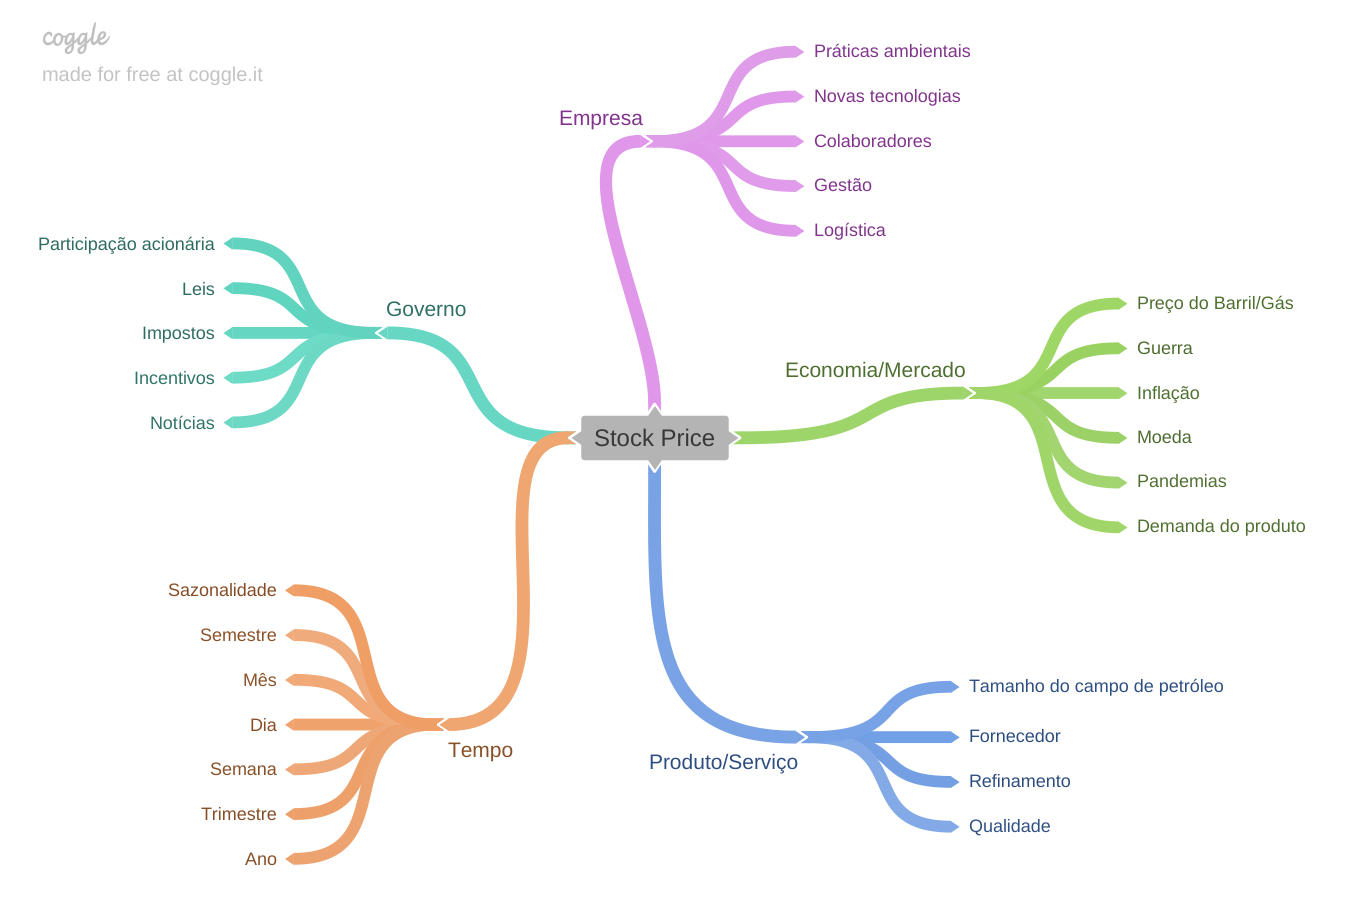

In [20]:
Image('../reports/Stock_Price_mindmap_v2.png')

## 2.2 Lista de hipóteses empresa

1. Empresas que aplicam praticas ambientais tiveram em média um crescimento ano a ano superior a 10% no preço das ações em relação as que não possuem.
2. Empresas que utilizam de tecnologias mais recentes possuem em média um P/L 30% superior as que não utilizam.
3. Empresas com mais colaboradores tiveram em média um descresimo de 5% no preço das ações em relação as que possuem menos.
4. Empresas com maior equidade nas cadeiras de liderença (50/50) tiveram em média um aumento de 25% no preço das ações.
5. Empresas com logística própria possuem em média o P/L 20% inferior.

## 2.3 Lista de hipóteses Economia/Mercado

1. A cada 50% de aumento do preço do barril de petroleo a cotação das ações das empresas de petroleo sobe em média 30%.
2. A cada 40% de aumento do preço do gás natural a cotação das ações das empresas de petroleo sobe em média 10%.
3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
4. A medida de a inflação acumulada cresce 1% as ações caem em média 5%.
5. Em períodos trimestrais onde o Real desvaloriza em media 20% as ações valorizam em média 10%.
6. Para cada 10% de aumento de casos de Covid as ações caem em média 3%.
7. A medida que a demanda do setor de pretoleo e derivados aumenta em média 10% as ações aumentam em média 15%.

## 2.4 Lista de hipóteses Produto/Serviço

1. Para cada 1.000 m³ de poço de petroleo pertencente a empresa o P/L aumenta 0,5%.
2. Empresas com processo de refinamento interno possuem um aumento anual médio de 20% das ações em relação as demais.

## 2.5 Lista de hipóteses Governo

1. A medida que impostos caem 10% as ações das empresas sobem em média 5%.
2. Empresas onde o governo possui participação acionário possuem em média 20% a mais de P/L.
3. Empresas que o governo possui participação rendem em média 5% mais ao longo dos anos em comparação as demais.
4. Petrobras cresce em média 20% a mais nas ações do que as demais
5. Petrobras possui volatilidade média 10% maior do que as demais

## 2.6 Lista de hipóteses Tempo

1. Ações nos meses de fevereiro rendem em média 5% menos em relação aos demais meses.
2. As ações no 3 trimestre rendem em média 5% mais em relação aos demais trimestres.
3. Os 10 primeiros dias de cada mês rendem em média 10% mais do que os demais dias.
4. A 3ª semana de cada mês rendem em média 5% menos do que as demais semanas.

## 2.7 Lista final de hipóteses

1. A cada 50% de aumento do preço do barril de petroleo a cotação das ações das empresas de petroleo sobe em média 30%.
2. A cada 40% de aumento do preço do gás natural a cotação das ações das empresas de petroleo sobe em média 10%.
3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
4. A medida de a inflação acumulada cresce 1% as ações caem em média 5%.
5. Em períodos trimestrais onde o Real desvaloriza em media 20% as ações valorizam em média 10%.
6. Ações nos meses de fevereiro rendem em média 5% menos em relação aos demais meses.
7. As ações no 3 trimestre rendem em média 5% mais em relação aos demais trimestres.
8. Os 10 primeiros dias de cada mês rendem em média 10% mais do que os demais dias.
9. A 3ª semana de cada mês rendem em média 5% menos do que as demais semanas.
10. Empresas que o governo possui participação rendem em média 5% mais ao longo dos anos em comparação as demais.

## 2.8 Feature Engineering

### 2.8.1 Features for modeling time

In [21]:
# Features for time
df2 = df2.reset_index()

df2['day'] = df2['Date'].dt.day

df2['month'] = df2['Date'].dt.month

df2['year'] = df2['Date'].dt.year

df2['day_of_week'] = df2['Date'].dt.day_of_week

df2['week_of_year'] = df2['Date'].dt.isocalendar().week

df2['month_year'] = df2['Date'].dt.strftime('%Y-%m')

df2['quarter'] = df2['month'].apply(lambda x: 4 if x >= 10 else 3 if x >= 7 else 2 if x >= 4 else 1)

df2 = df2.set_index('Date')

### 2.8.2 Features to normalize data and calculate profitability

In [22]:
# Create daily profit for each share
df_profit = pd.DataFrame()

for i in cols:
    df_profit[i+'_profit'] = df2[i] / df2[i].shift() * 100 - 100

# Feature that represents the average stock return
df_profit['mean_profit'] = df_profit.iloc[:,:10].mean(axis=1)

# Concat new feature
df2 = pd.concat([df2, df_profit], axis=1)

### 2.8.3 Features for analyzing the IPCA

In [23]:
df_ipca['month_year'] = df_ipca['date'].dt.strftime('%Y-%m')

df_ipca['cumsum'] = df_ipca['actual'].cumsum()

# Normalize ipca
df_ipca['ipca_standt_cumsum'] = df_ipca['cumsum'] / df_ipca['cumsum'].shift() * 100 - 100

### 2.8.4 Make features for bollinger bands strategy

In [24]:
# ------------------ Make features for bbands in each shares ---------------------------------------
df_bbands = {}
for name in cols[:-3]:
    df_bbands[name] = pd.DataFrame()
    df_bbands[name] = make_bbands(data=df2, abb=name)

# Concat all results
df2_new = pd.concat([df_bbands['RRRP3'], df_bbands['CSAN3'], df_bbands['DMMO3'], df_bbands['ENAT3'], df_bbands['PRIO3'], 
                    df_bbands['PETR3'], df_bbands['RECV3'], df_bbands['RPMG3'], df_bbands['UGPA3'], df_bbands['VBBR3']], 
                    keys=['RRRP3', 'CSAN3', 'DMMO3', 'ENAT3', 'PRIO3', 'PETR3', 'RECV3', 'RPMG3', 'UGPA3', 'VBBR3'], axis=1)

# 3.0 Portfolio Strategy

In [25]:
df3 = df2_new.copy()

- Indice Bovespa (BOVA11) como Baseline
- Simular indice de petroleo com uma carteira com pesos iguais como baseline
- Estratégia: hold como baseline

## 3.1 Buy & Hold (Baseline)

## 3.2 Rebalancing

## 3.3 Bollinger Bands

In [26]:
btest1 = btesting(df3 ,'RRRP3')

btest2 = btesting(df3 ,'CSAN3')

btest3 = btesting(df3 ,'DMMO3')

btest4 = btesting(df3 ,'ENAT3')

btest5 = btesting(df3 ,'PRIO3')

btest6 = btesting(df3 ,'PETR3')

btest7 = btesting(df3 ,'RECV3')

btest8 = btesting(df3 ,'RPMG3')

btest9 = btesting(df3 ,'UGPA3')

btest10 = btesting(df3 ,'VBBR3')


results = bt.run(btest1, btest2, btest3, btest4, btest5 , btest6, btest7, btest8, btest9, btest10)

results.display()

f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-pack

Stat                 RRRP3 bbands    CSAN3 bbands    DMMO3 bbands    ENAT3 bbands    PRIO3 bbands    PETR3 bbands    RECV3 bbands    RPMG3 bbands    UGPA3 bbands    VBBR3 bbands
-------------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------
Start                2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02
End                  2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11
Risk-free rate       0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%

Total Return         -1.95%          -13.75%         70.92%          7.12%           1.33%           4.78%           9

f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)


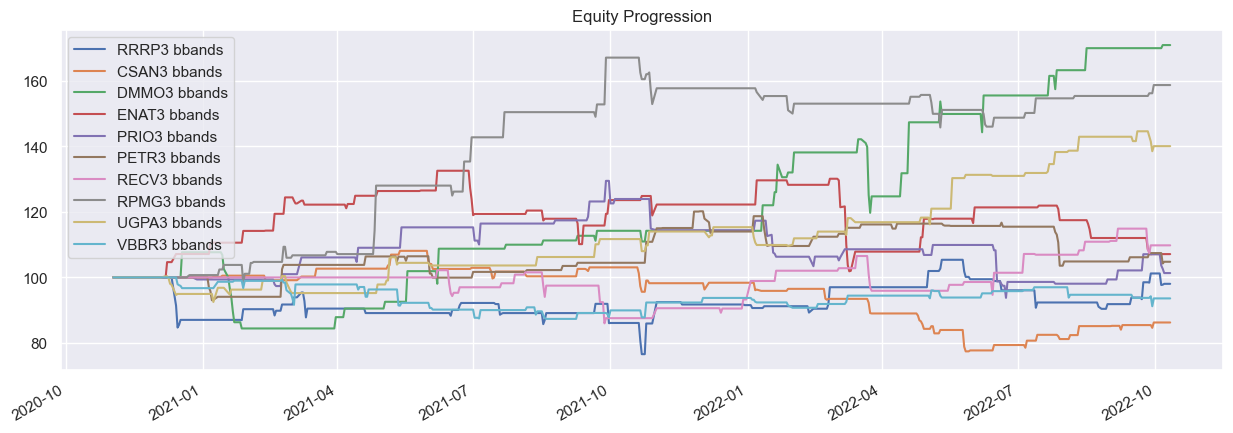

In [27]:
results.plot();

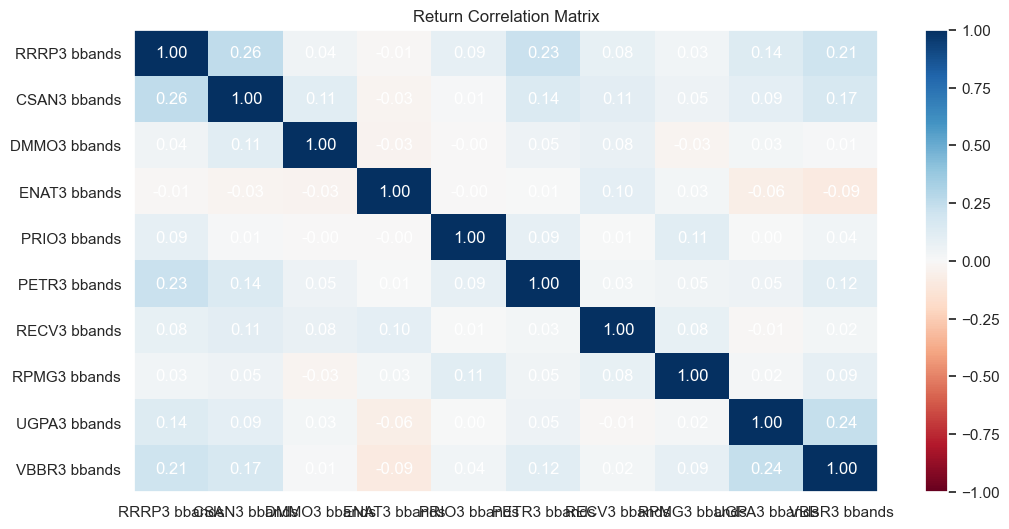

In [28]:
results.plot_correlation();

# 4.0 Análise exploratória dos dados

In [29]:
df4 = df2.copy()

## 4.1 Análise Univariada

### 4.1.2 Numerical Variable

1. Análise de ações por risco/retorno
2. Métricas:
    - Volatividade
    - Min e Max
    - Média
    - Desvio Padrão

In [31]:
#profile = ProfileReport(df4)
#profile.to_file('../reports/output_v1.html')

In [243]:
num_att = df4.select_dtypes(include=['int64', 'float64'])
num_att = num_att[['RRRP3_profit', 'CSAN3_profit', 'DMMO3_profit',
       'ENAT3_profit', 'PRIO3_profit', 'PETR3_profit',
       'RECV3_profit', 'RPMG3_profit', 'UGPA3_profit',
       'VBBR3_profit']]

# Central tendency and Dispersion
d1 = pd.DataFrame (num_att.apply( lambda x: x.max() - x.min() )).T
d2 = num_att.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate and organize
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['symbols', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['symbols', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2.sort_values(['range', 'std'])

,symbols,min,max,range,mean,median,std,skew,kurtosis
9,VBBR3_profit,-7.218,9.569,16.787,0.030,0.000,2.042,0.427,1.923
3,ENAT3_profit,-8.043,10.604,18.647,0.157,0.000,2.875,0.275,0.879
1,CSAN3_profit,-8.717,10.121,18.838,0.022,0.000,2.108,0.516,2.896
6,RECV3_profit,-9.259,10.625,19.884,0.189,0.000,2.987,0.133,0.513
0,RRRP3_profit,-12.493,12.928,25.421,0.175,0.000,2.981,0.179,2.010
8,UGPA3_profit,-12.334,15.093,27.428,-0.008,0.000,2.504,0.189,4.156
5,PETR3_profit,-20.480,10.216,30.696,0.244,0.000,2.430,-0.736,11.049
4,PRIO3_profit,-10.763,29.944,40.706,0.335,0.000,3.337,1.565,12.101
2,DMMO3_profit,-23.179,35.556,58.734,0.186,0.000,4.773,2.282,13.448
7,RPMG3_profit,-13.211,73.841,87.052,0.027,0.000,4.373,9.469,148.943


## 4.2 Análise Bivariada

In [32]:
# select collumns to validate hypotheses
aux = df4[['day', 'month', 'year', 'day_of_week', 'month_year', 'quarter', 'mean_profit', 'BZ_profit',
       'NG_profit', 'BRL_profit']]

aux.columns = ['day', 'month', 'year', 'day_of_week', 'month_year', 'quarter', 'oil_comp_index', 'oil_barrel',
       'nat_gas', 'brl_real']

aux.head()

,day,month,year,day_of_week,month_year,quarter,oil_comp_index,oil_barrel,nat_gas,brl_real
Date,,,,,,,,,,
2020-11-03,3,11,2020,1,2020-11,4,NaN,NaN,NaN,NaN
2020-11-04,4,11,2020,2,2020-11,4,1.303,3.828,-0.425,0.240
2020-11-05,5,11,2020,3,2020-11,4,4.678,-0.728,-3.414,-1.597
2020-11-06,6,11,2020,4,2020-11,4,0.785,-3.616,-1.835,-2.465
2020-11-09,9,11,2020,0,2020-11,4,3.138,7.478,-1.004,-2.909


### H1. O crescimento médio do preço do barril de petroleo anual (YoY) é 20% maior do que os das ações das empresas petrolíferas 
**FALSE** O barril de petroleo em média está 8,82% inferior em comparação ao crescimento médio das empresas petrolíferas

<Figure size 2200x800 with 0 Axes>

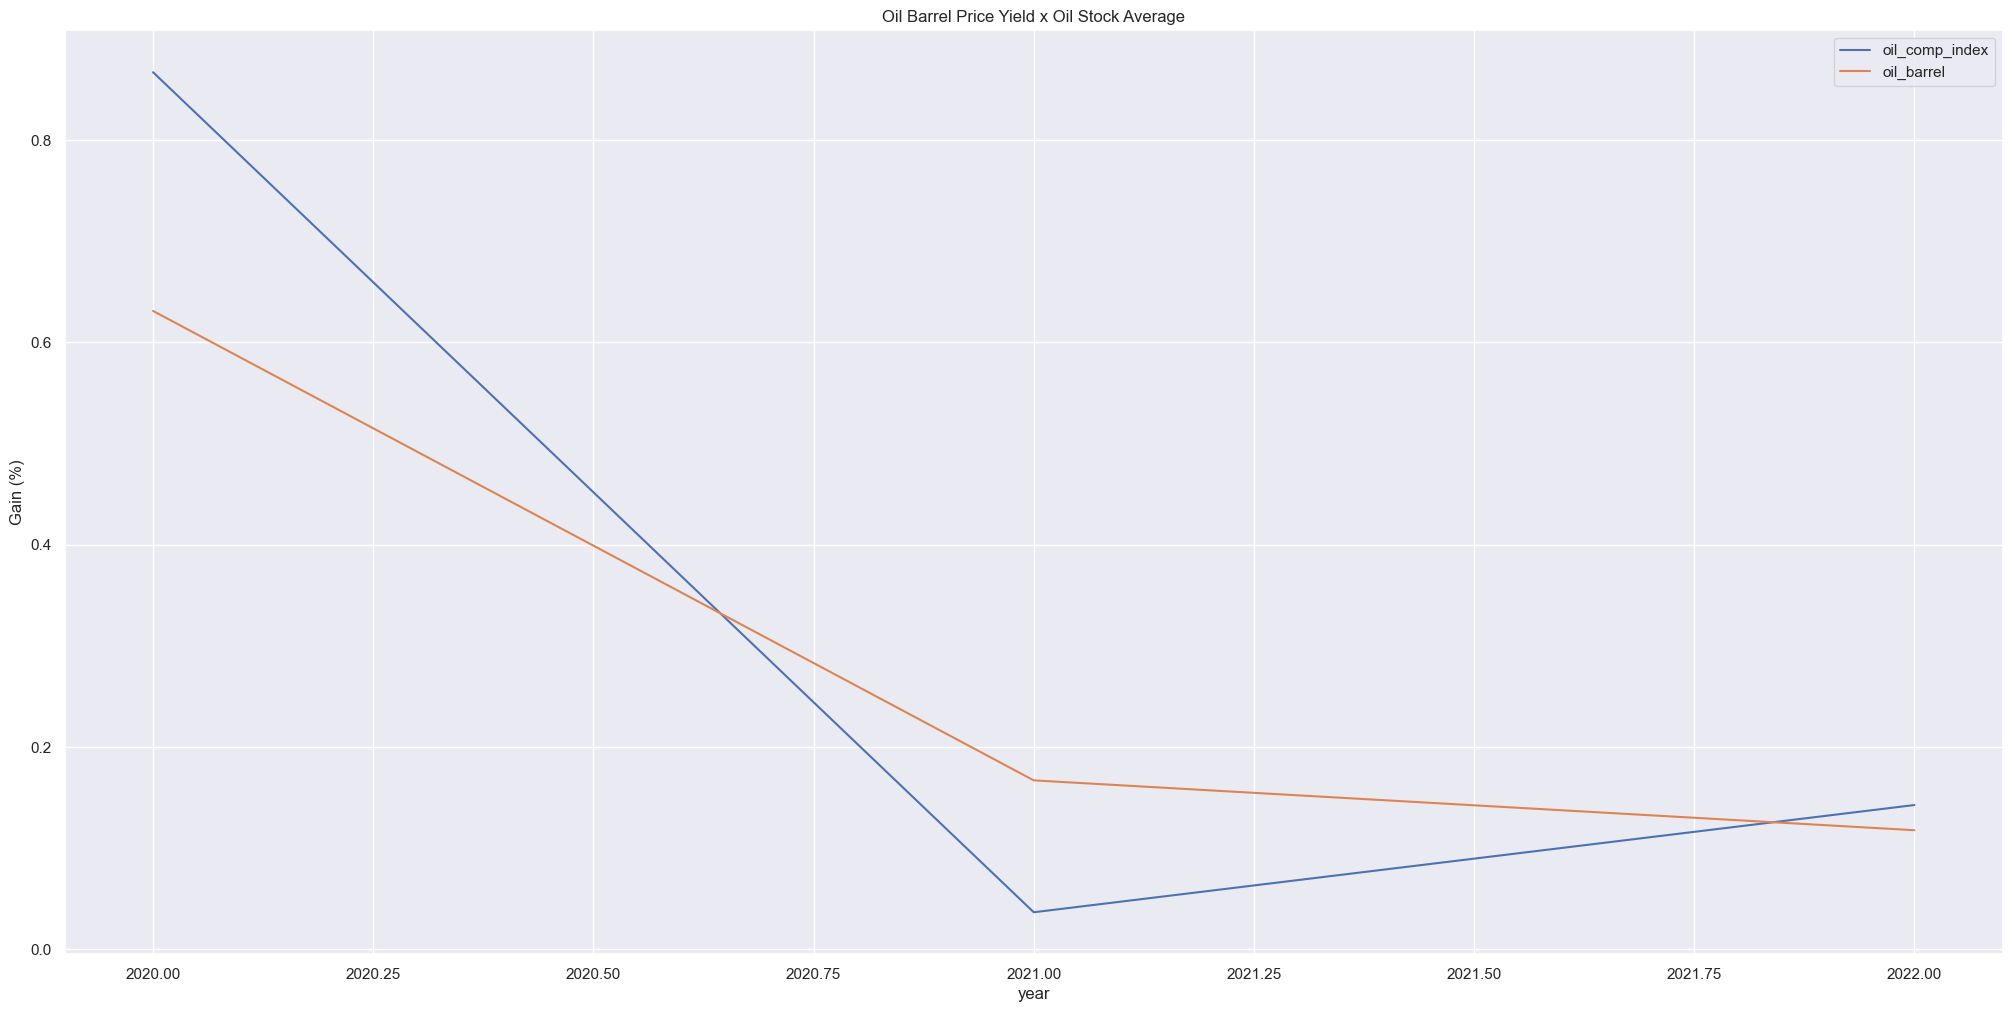

In [33]:
# Calculate mean profit of shares over year
plt.figure(figsize=(22,8))
aux1 = aux.groupby('year').mean().reset_index()[['year', 'oil_comp_index']]
ax = aux1.plot(x='year')

# Calculate mean of oil barrel prices over year
aux2 = aux.groupby('year').mean().reset_index()[['year', 'oil_barrel']]
aux2.plot(x='year', ax=ax)
plt.title('Oil Barrel Price Yield x Oil Stock Average')
plt.ylabel('Gain (%)');

- It is possible to see that in the three years both the values of the returns between the average of the oil stocks and the price of a barrel of oil follow a trend

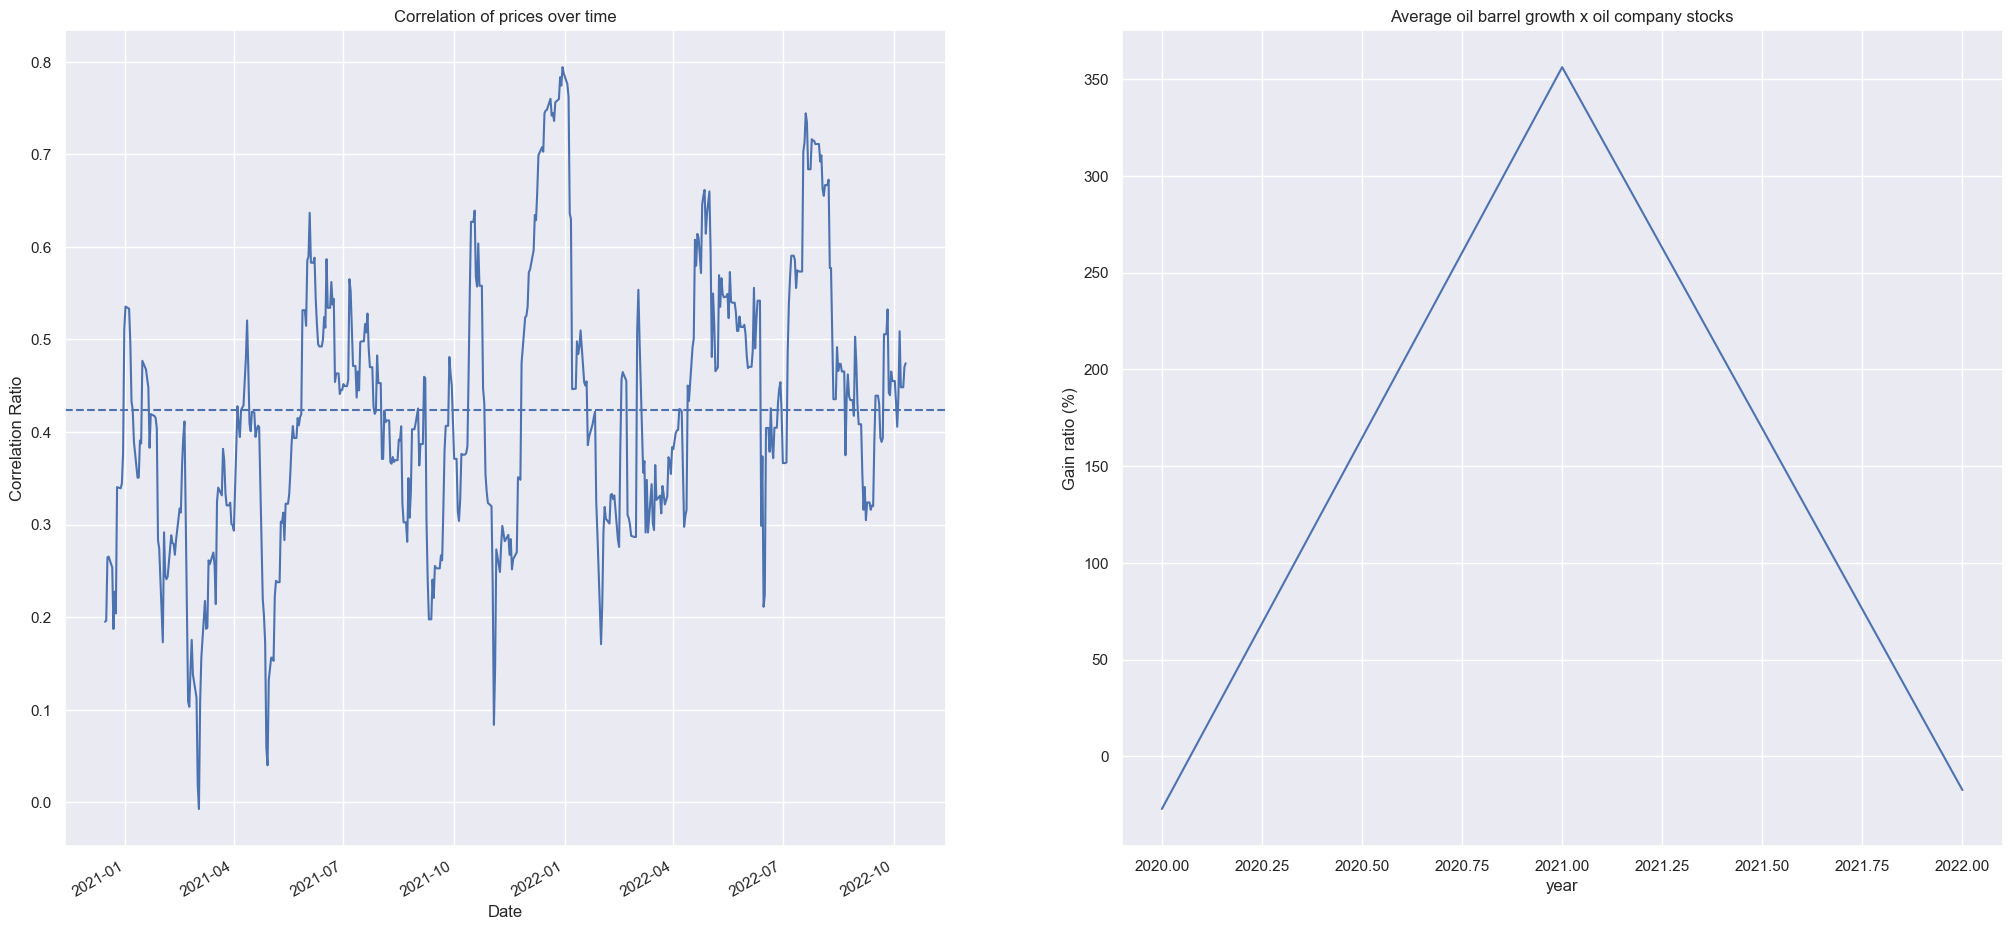

In [34]:
plt.subplot(1, 2, 1)

# Calculating monthly correlation
aux['oil_comp_index'].rolling(30).corr(aux['oil_barrel']).plot()
mean_corr = aux['oil_comp_index'].rolling(30).corr(aux['oil_barrel']).mean()

plt.axhline(mean_corr, linestyle='--')
plt.title('Correlation of prices over time')
plt.ylabel('Correlation Ratio');


plt.subplot(1, 2, 2)

# Checking proportional gains in oil barrel revenues
aux3 = aux.groupby('year').mean().reset_index()[['year', 'oil_comp_index', 'oil_barrel']]
aux3['proportion'] = aux3['oil_barrel'] / aux3['oil_comp_index'] * 100 - 100

sns.lineplot(x='year', y='proportion', data=aux3)
plt.title('Average oil barrel growth x oil company stocks')
plt.ylabel('Gain ratio (%)');

- (1 Figure) The correlation between prices fluctuates considerably over time, averaging 0.4, typically a weak correlation.
- (2 Figure) In this chart it is possible to see that from 2020 to 2021 the barrel price appreciation against oil companies has a jump, but between 2021 and 2022 the difference adjusts

In [35]:
aux3

,year,oil_comp_index,oil_barrel,proportion
0,2020,0.867,0.631,-27.215
1,2021,0.037,0.167,356.160
2,2022,0.143,0.118,-17.463


- We can't see a linear growth trend, so we will take a 3-year average.

In [36]:
# Average growth 
aux3[['oil_comp_index', 'oil_barrel']].mean()

oil_comp_index   0.349
oil_barrel       0.305
dtype: float64

- On average the barrel price appreciates 8.82% less than the share price in the oil and gas industry.

### H2. O crescimento médio do preço de gás natural mensal (MoM) é 30% maior do que os das ações das empresas petrolíferas 
**TRUE** Em média o rendimento do preço de gás natural esteve 212,5% superior.

<Figure size 2200x800 with 0 Axes>

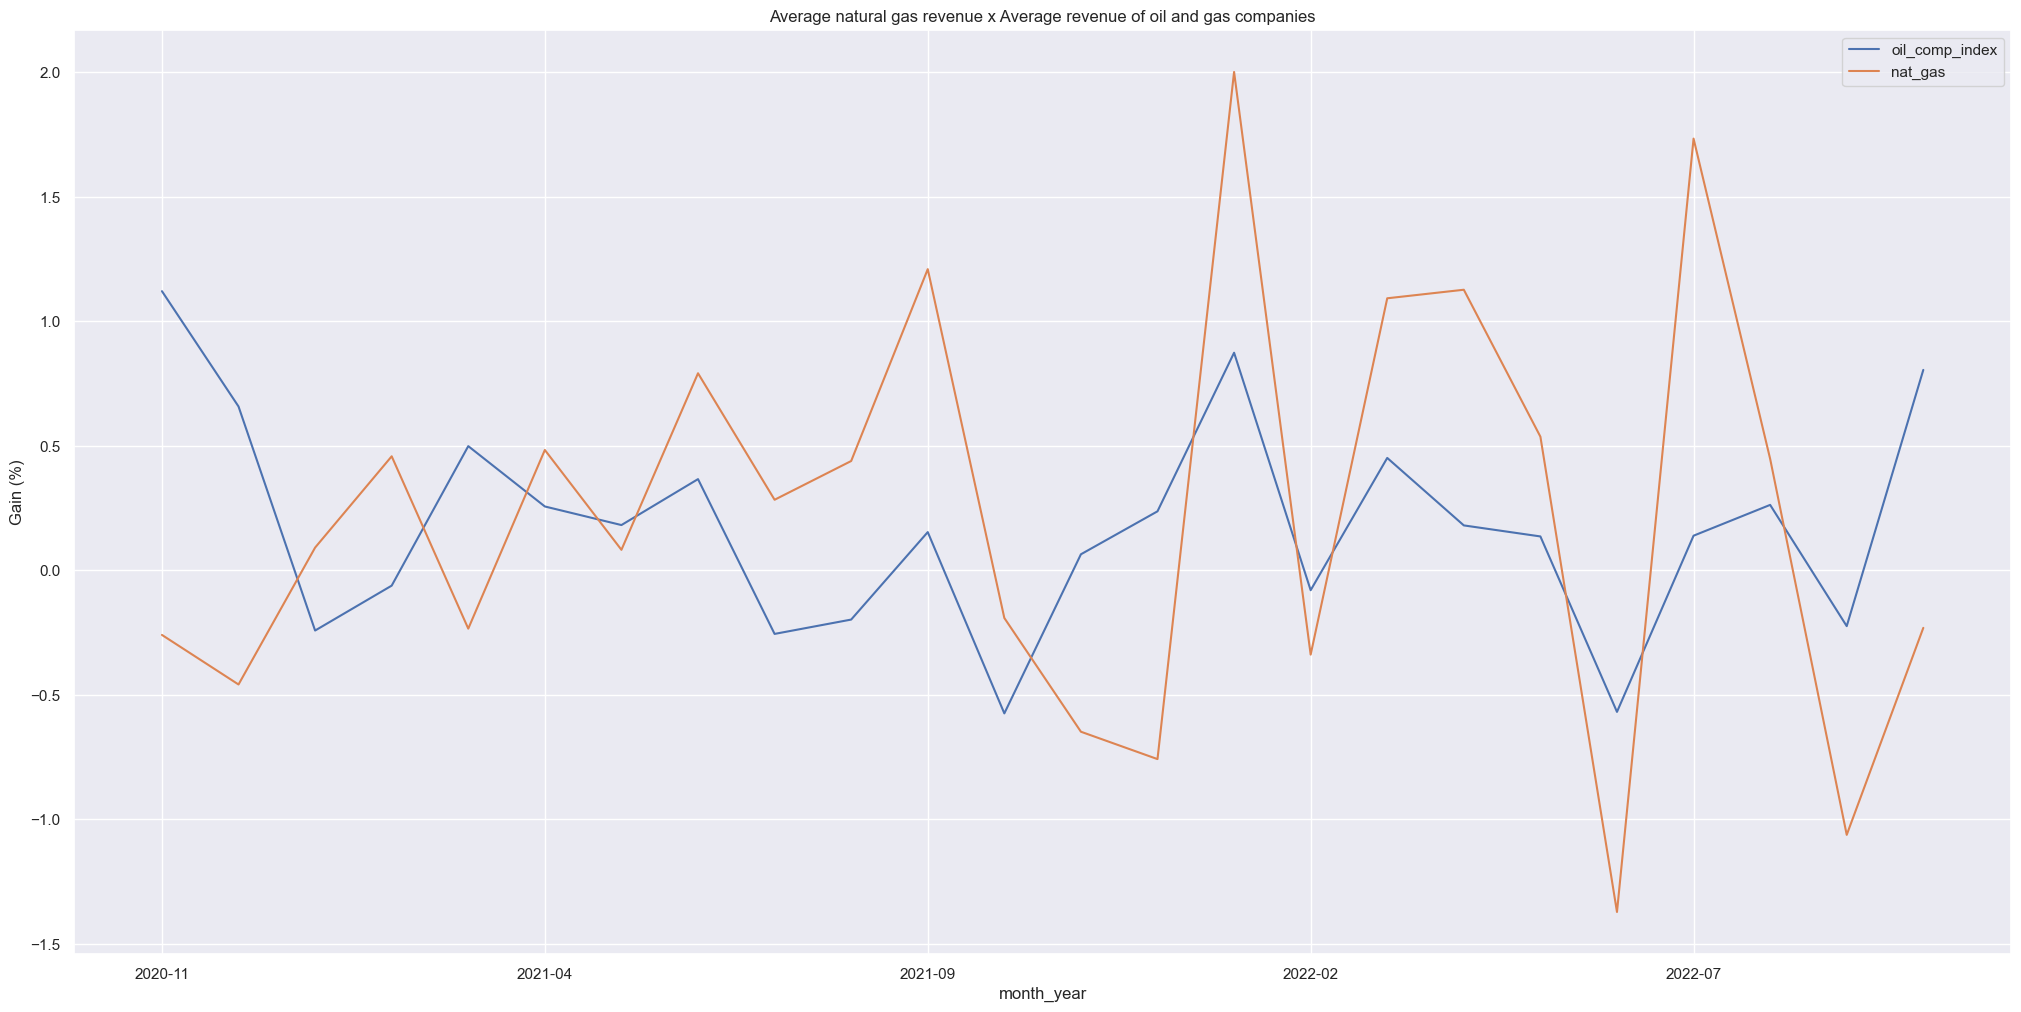

In [37]:
plt.figure(figsize=(22,8))

# Calculating average monthly growth for average oil company stock returns
aux1 = aux.groupby('month_year').mean().reset_index()[['month_year', 'oil_comp_index']]
ax = aux1.plot(x='month_year')

# Calculating average monthly growth for average natural gas returns
aux2 = aux.groupby('month_year').mean().reset_index()[['month_year', 'nat_gas']]
aux2.plot(x='month_year', ax=ax)

plt.title('Average natural gas revenue x Average revenue of oil and gas companies')
plt.ylabel('Gain (%)');

- Both do not appear to have high correlations or trends

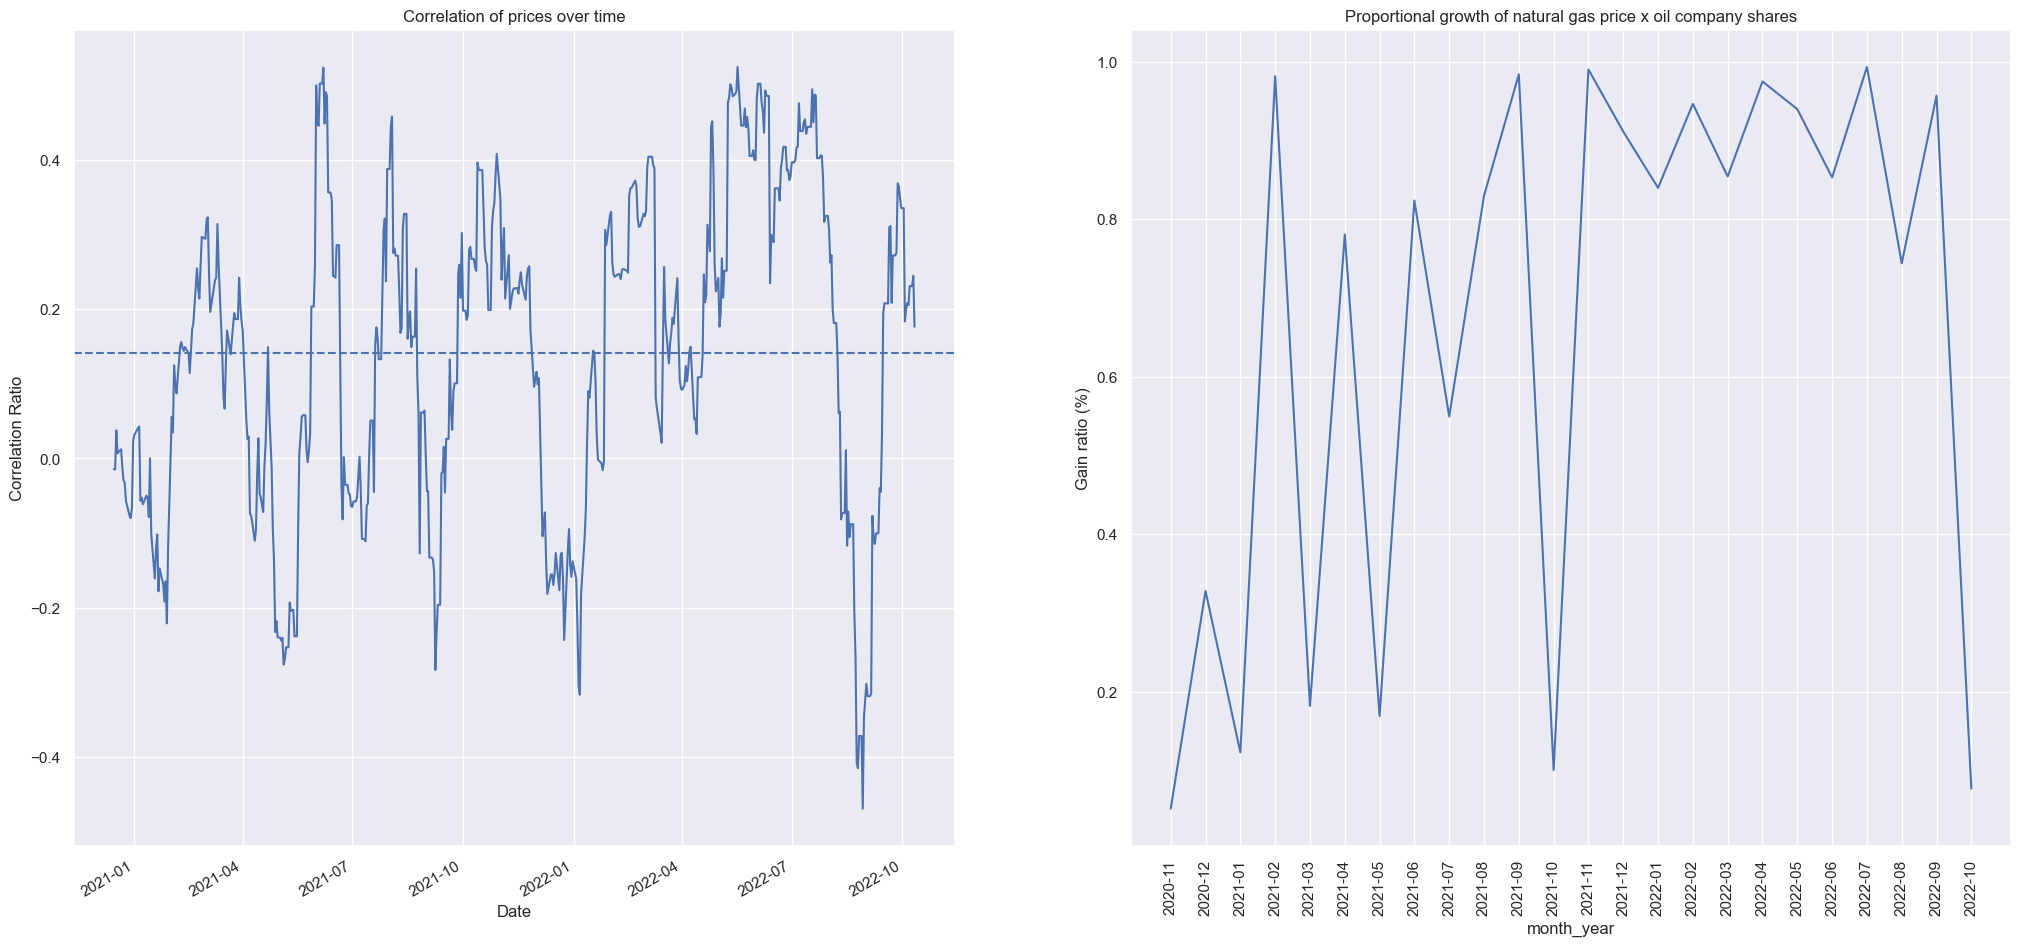

In [38]:
plt.subplot(1, 2, 1)

# Calculating monthly correlation
aux['oil_comp_index'].rolling(30).corr(aux['nat_gas']).plot()
mean_corr = aux['oil_comp_index'].rolling(30).corr(aux['nat_gas']).mean()

plt.axhline(mean_corr, linestyle='--')
plt.title('Correlation of prices over time')
plt.ylabel('Correlation Ratio');


plt.subplot(1, 2, 2)

# Proportion of natural gas growth compared to oil companies
aux2 = aux.groupby('month_year').mean().reset_index()[['month_year', 'oil_comp_index', 'nat_gas']]
aux2['proportion'] = aux2['nat_gas'] / aux2['oil_comp_index'] * 100 - 100

# Normalizing values
aux3 = aux2[['oil_comp_index', 'nat_gas']].apply(lambda x: x*x, axis=1)
aux3['sum'] = aux3.sum(axis=1)
aux3['month_year'] = aux2['month_year']

# Calculating percentage gains
aux3['oil_comp_index_perc'] = aux3.apply(lambda x: x['oil_comp_index'] / x['sum'], axis=1)
aux3['nat_gas_perc'] = aux3.apply(lambda x: x['nat_gas'] / x['sum'], axis=1)

sns.lineplot(x='month_year',  y='nat_gas_perc', data=aux3);

plt.title('Proportional growth of natural gas price x oil company shares')
plt.xticks(rotation=90)
plt.ylabel('Gain ratio (%)');

- (Figure 1) No strong correlation is shown with daily data, the average value is 0.14.
- (Figure 2) It represents a strong percentage increase in natural gas yield compared to stocks, however we have a lot of oscillations, so we need an average.

In [39]:
aux3[['oil_comp_index_perc', 'nat_gas_perc']].mean()

oil_comp_index_perc   0.334
nat_gas_perc          0.666
dtype: float64

- We have in conclusion the average percentage of earnings from stocks and natural gas, with the highlight being gas, which comprises double the earnings.

### H3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
**TRUE** Os dois primeiros meses da guerra russo-ucraniana refletiram em valorização de aproximadamente 40% do valor das ações, entretanto não é possível afirmar que todas as guerras possuem mesmos efeitos.

Para essa análise será considerada a guerra russo-ucraniana iniciada em 23 de Fevereiro de 2022

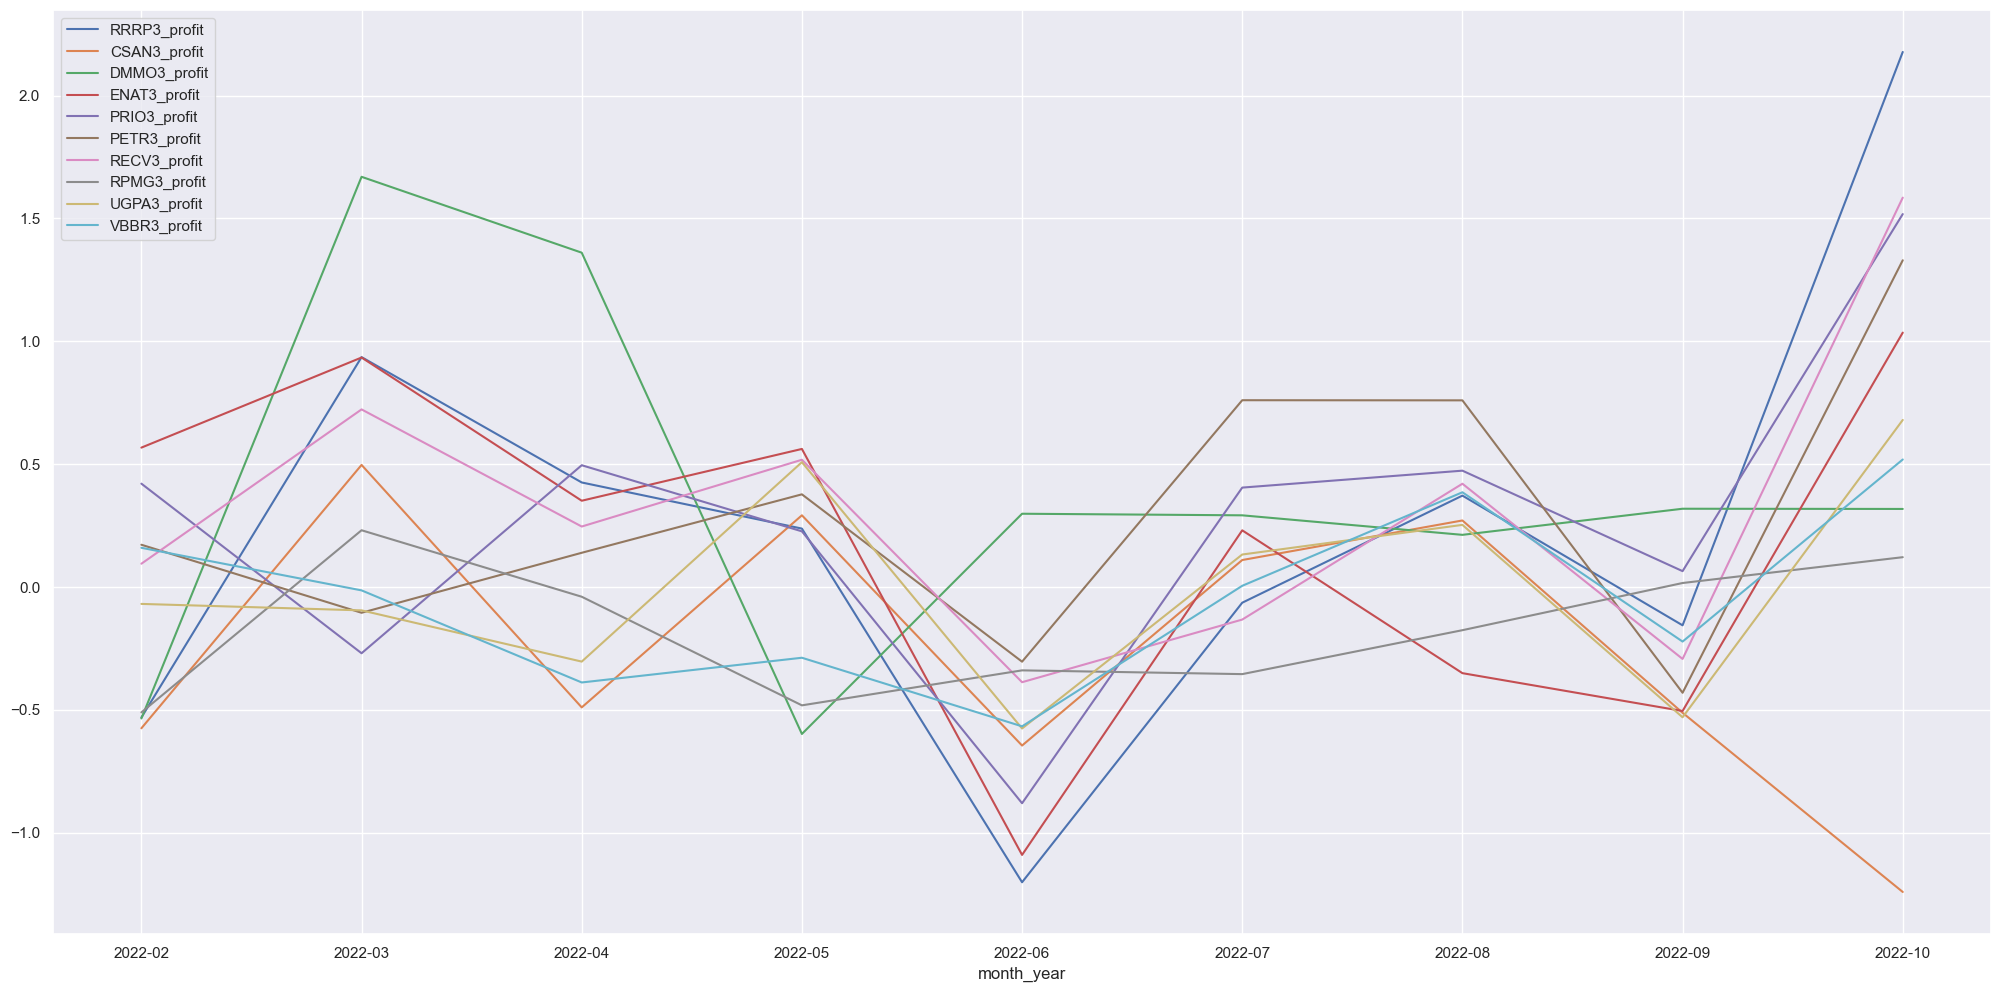

In [40]:
# Collecting Stock Yield Data for Individual Analysis
aux1 = df4[['RRRP3_profit', 'CSAN3_profit', 'DMMO3_profit',
       'ENAT3_profit', 'PRIO3_profit', 'PETR3_profit',
       'RECV3_profit', 'RPMG3_profit', 'UGPA3_profit',
       'VBBR3_profit', 'month_year']]

aux1 = aux1[aux1['month_year'] >= '2022-02']

aux1.groupby('month_year').mean().reset_index().set_index('month_year').plot();

- Due to the fluctuations of each paper it is difficult to see clearly if there has been a direct impact, you will need to use a paper that represents the shares of oil and gas companies.

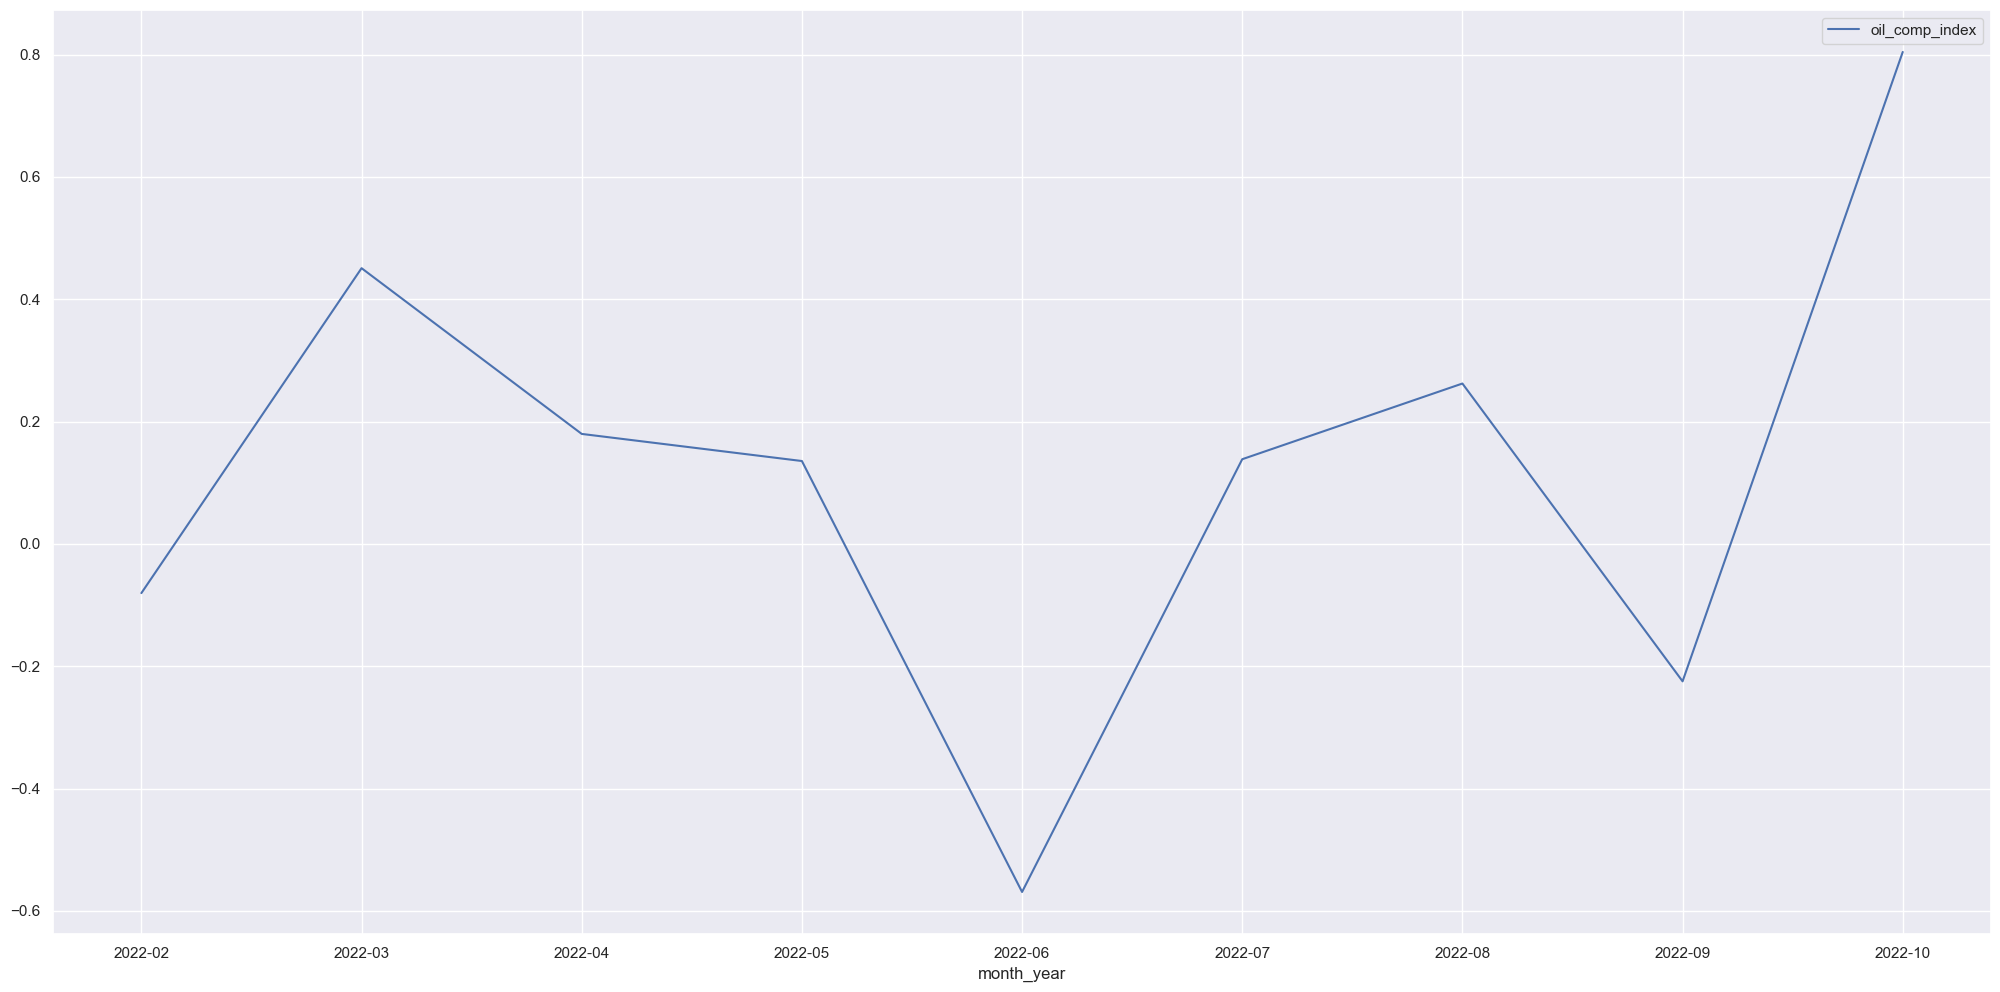

In [41]:
aux1 = aux[aux['month_year'] >= '2022-02']

aux1 = aux1[['month_year', 'oil_comp_index']].groupby('month_year').mean().reset_index()

aux1.set_index('month_year').plot();

In [42]:
aux1

,month_year,oil_comp_index
0,2022-02,-0.080
1,2022-03,0.451
2,2022-04,0.180
3,2022-05,0.135
4,2022-06,-0.569
5,2022-07,0.138
6,2022-08,0.262
7,2022-09,-0.225
8,2022-10,0.804


- It is possible to see that immediately (month 02) there was no difference observing an average, however in the following month we had an impact of 45% in the increase of the value.

### H4. Em média as ações de empresas de petróleo e gás crescem 5% a mais do que a inflação.
**FALSE** A inflação cresce significativamente mais do que o preço das ações

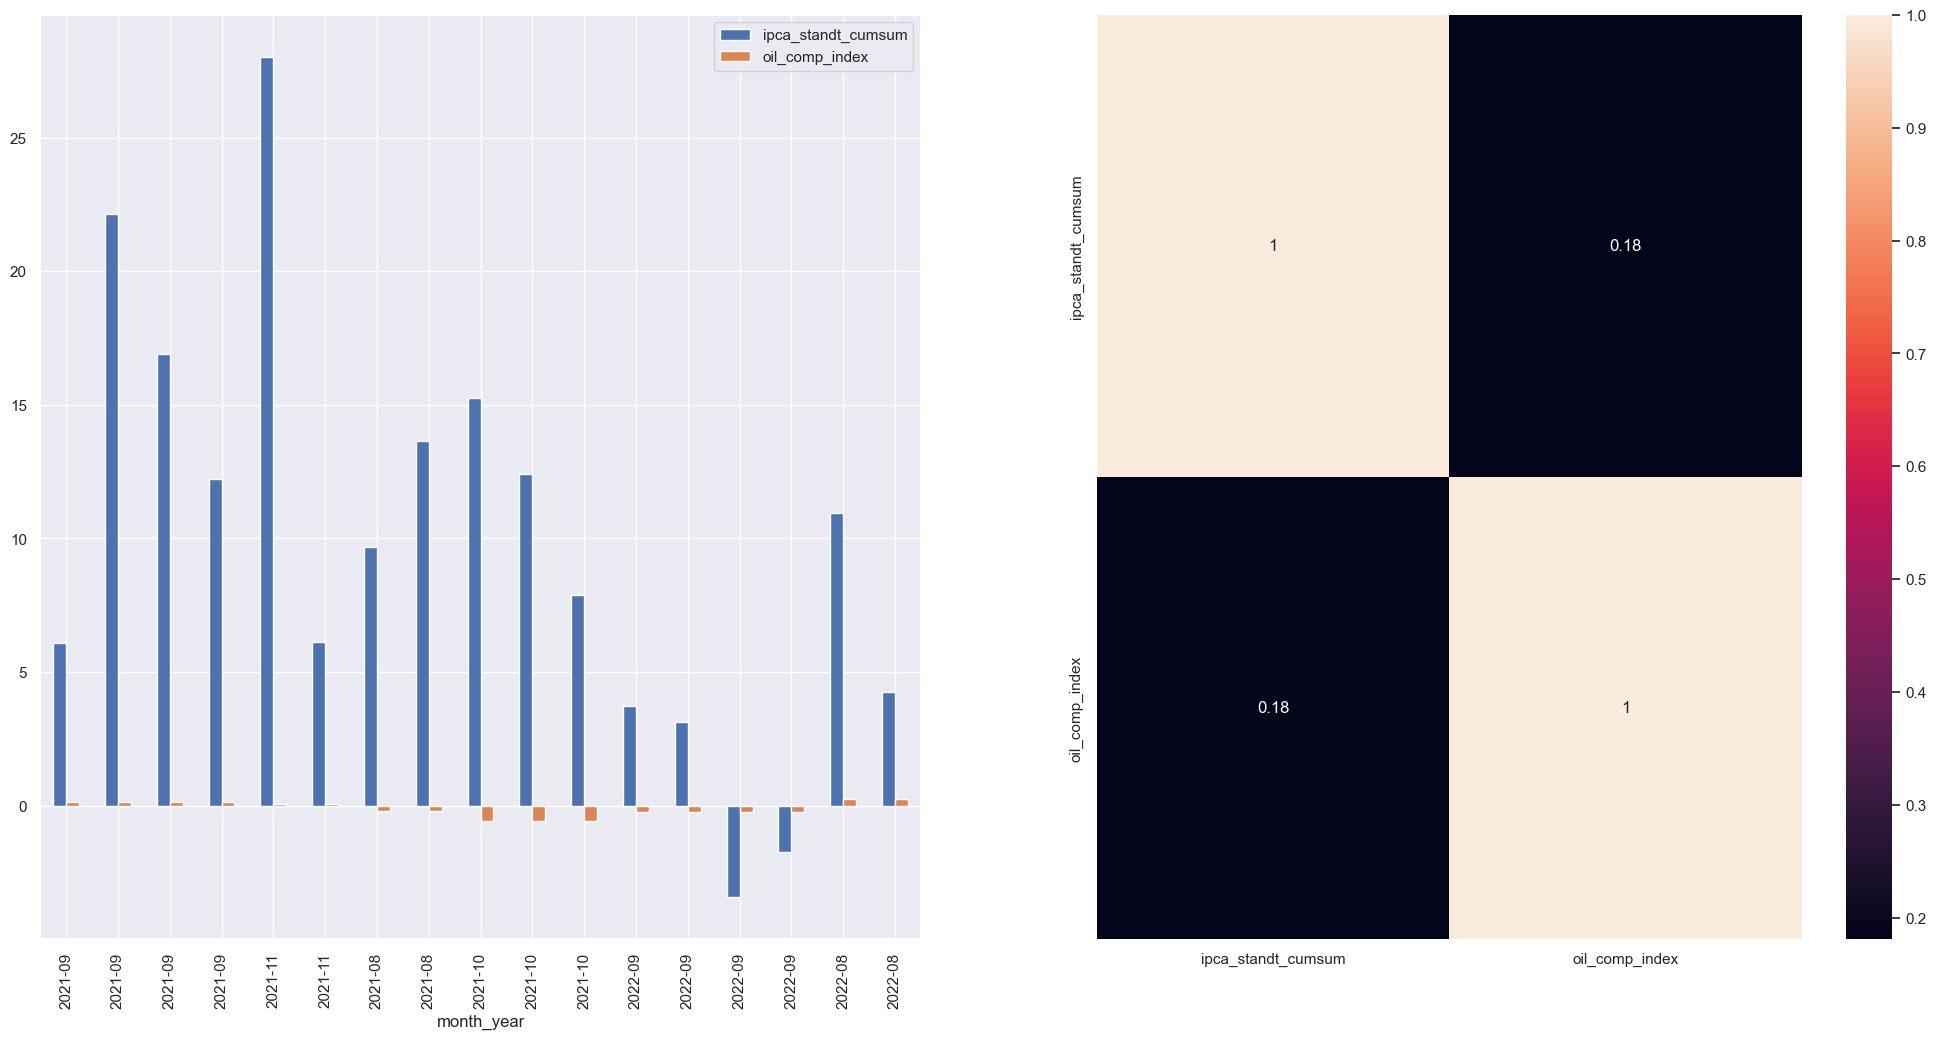

In [43]:
# Calculating monthly returns on oil company stocks to compare with IPCA index
aux1 = aux[['month_year', 'oil_comp_index']].groupby('month_year').mean().reset_index()

aux1 = pd.merge(df_ipca, aux1, how='inner', on='month_year')

# Cutting out some outliers for better visualization of the graph
aux1 = aux1.tail(17)

ax = plt.subplot(1, 2, 1)

aux1[['ipca_standt_cumsum', 'month_year', 'oil_comp_index']].plot(x='month_year', kind='bar', ax=ax)

plt.subplot(1, 2, 2)
sns.heatmap(aux1[['ipca_standt_cumsum', 'oil_comp_index']].corr(), annot=True);

- (Figure 1) Even when normalized, it is difficult to see the impact of inflation on stocks, but it is significant enough to say that inflation has a greater impact on stocks.
- (Figure 2) The correlation value indicates that the variables are practically uncorrelated.

### H5. Em períodos trimestrais onde o Real desvaloriza em media 5% as ações valorizam em média 10%.
**TRUE** Em média para 7% de desvalorização do real as ações valorizam em média 27%.

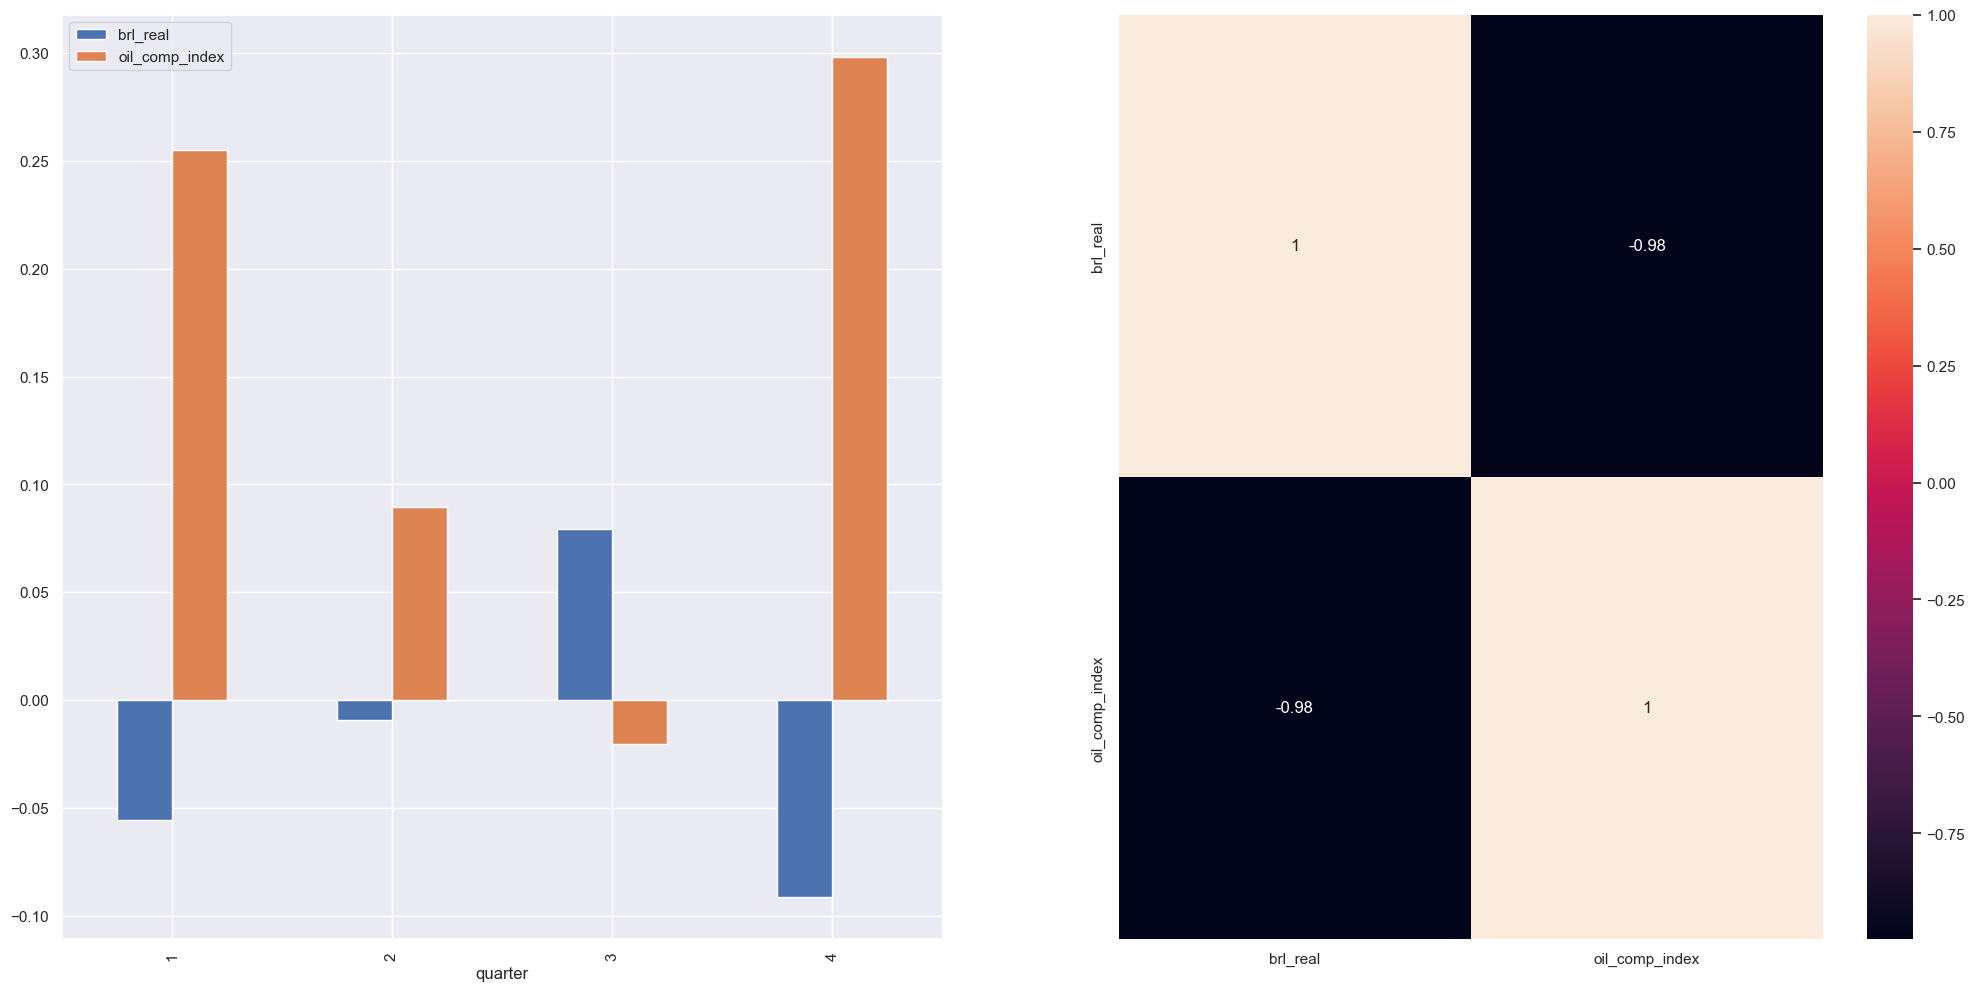

In [44]:
# Quarterly variation of stocks and brazilian currency
aux1 = aux[['brl_real', 'oil_comp_index', 'quarter']].groupby('quarter').mean()

ax = plt.subplot(1, 2, 1)
aux1.plot(kind='bar', ax=ax);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(),annot=True);

- You can see the inverse correlation that matches the hypothesis, the second figure shows a strong correlation.

In [45]:
aux1

,brl_real,oil_comp_index
quarter,,
1,-0.056,0.255
2,-0.009,0.090
3,0.079,-0.020
4,-0.091,0.298


In [46]:
aux1[aux1['oil_comp_index'] >= 0.2].mean()

brl_real         -0.073
oil_comp_index    0.277
dtype: float64

- We have two situations where it is possible to validate the hypothesis: 
1. In the 1st quarter, for a 6% drop in the real, the stock appreciates 25%.
2. In the 4th quarter, for a 9% drop in the real, the share appreciates 29%.

Finally for each 7% devaluation we have 27% appreciation.

### H6. Ações nos meses de fevereiro rendem em média 5% menos em relação aos demais meses.
**FALSE** O pior mês é Outubro com uma diferença média de 8,07 % entre fevereiro.

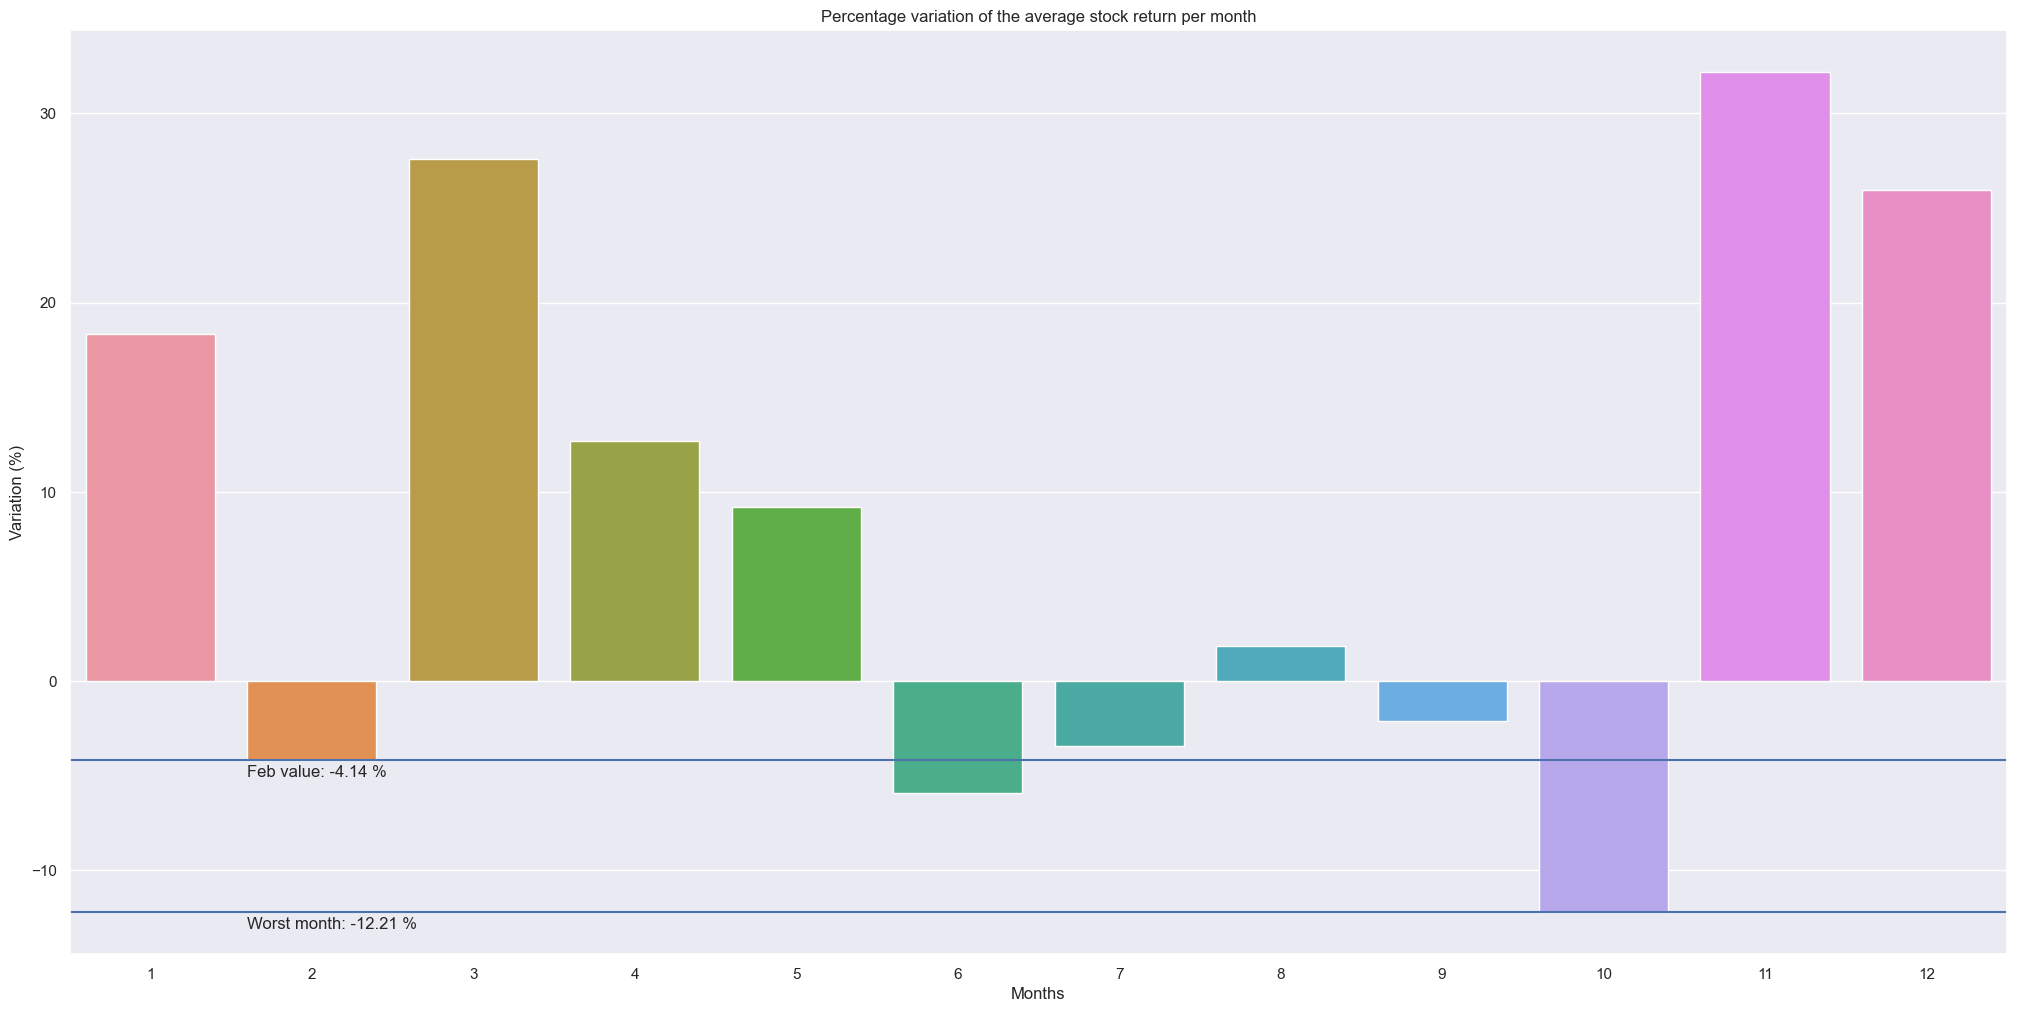

In [123]:
# Calculating variation of monthly percentage incomes
aux1 = aux[['month', 'oil_comp_index']].groupby('month').mean().reset_index()
aux1['oil_perc'] = aux1.apply(lambda x: (x['oil_comp_index'] / aux1['oil_comp_index'].sum())*100, axis=1)

sns.barplot(x='month', y='oil_perc', data=aux1)

# Legends for February
value_feb= aux1[aux1['month'] == 2]['oil_perc'].values[0]
plt.text(0.6,  value_feb-0.9, f'Feb value: {value_feb:.2f} %')
plt.axhline(value_feb)

# Legends for worst month
worst_value= aux1['oil_perc'].min()
plt.text(0.6,  worst_value-0.9, f'Worst month: {worst_value:.2f} %')
plt.axhline(worst_value)

plt.title('Percentage variation of the average stock return per month')
plt.xlabel('Months')
plt.ylabel('Variation (%)');

### H7. As ações no 3 trimestre rendem em média 5% mais em relação aos demais trimestres.
**FALSE** As ações do 3º trimestre possuem o pior rendimento médio, o melhor trimestre é o 4º com uma diferença para o 3º trimestre de aproximadamente 51,17 %.

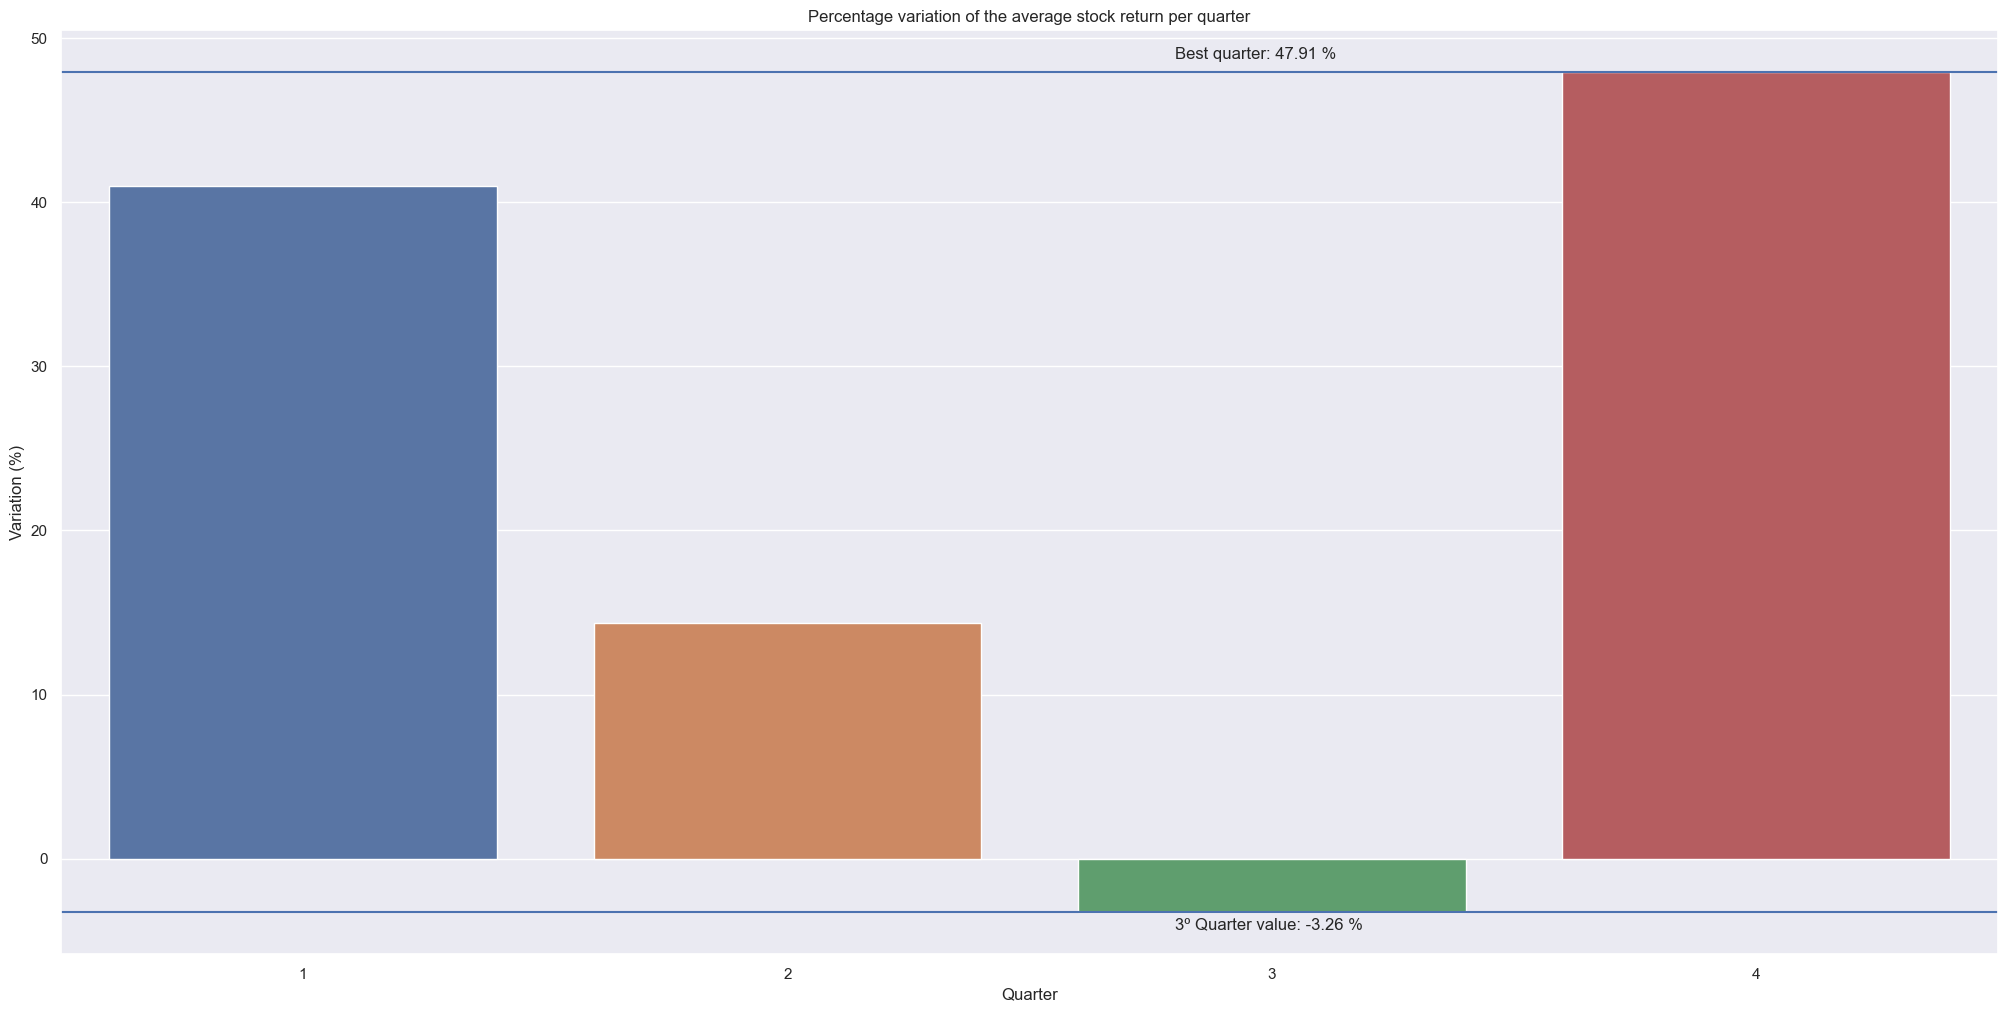

In [133]:
aux1 = aux[['quarter', 'oil_comp_index']].groupby('quarter').mean().reset_index()

aux1['oil_perc'] = aux1.apply(lambda x: (x['oil_comp_index'] / aux1['oil_comp_index'].sum())*100, axis=1)

sns.barplot(x='quarter', y='oil_perc', data=aux1)

# Legends for 3º Quarter
value_3quart= aux1[aux1['quarter'] == 3]['oil_perc'].values[0]
plt.text(1.8,  value_3quart-1.0, f'3º Quarter value: {value_3quart:.2f} %')
plt.axhline(value_3quart)

# Legends for best quarter
best_value= aux1['oil_perc'].max()
plt.text(1.8,  best_value+0.8, f'Best quarter: {best_value:.2f} %')
plt.axhline(best_value)

plt.title('Percentage variation of the average stock return per quarter')
plt.xlabel('Quarter')
plt.ylabel('Variation (%)');

### H8. Os 10 primeiros dias de cada mês rendem em média 10% mais do que os demais dias.
**FALSE** Os 10 primeiros dias rendem 1% a mais na média do que a segunda comparação.

- The comparison should be between days 1-10 compared to 20-31, however it does not generate a fair comparison, so let's divide the days of the month into 3 parts.

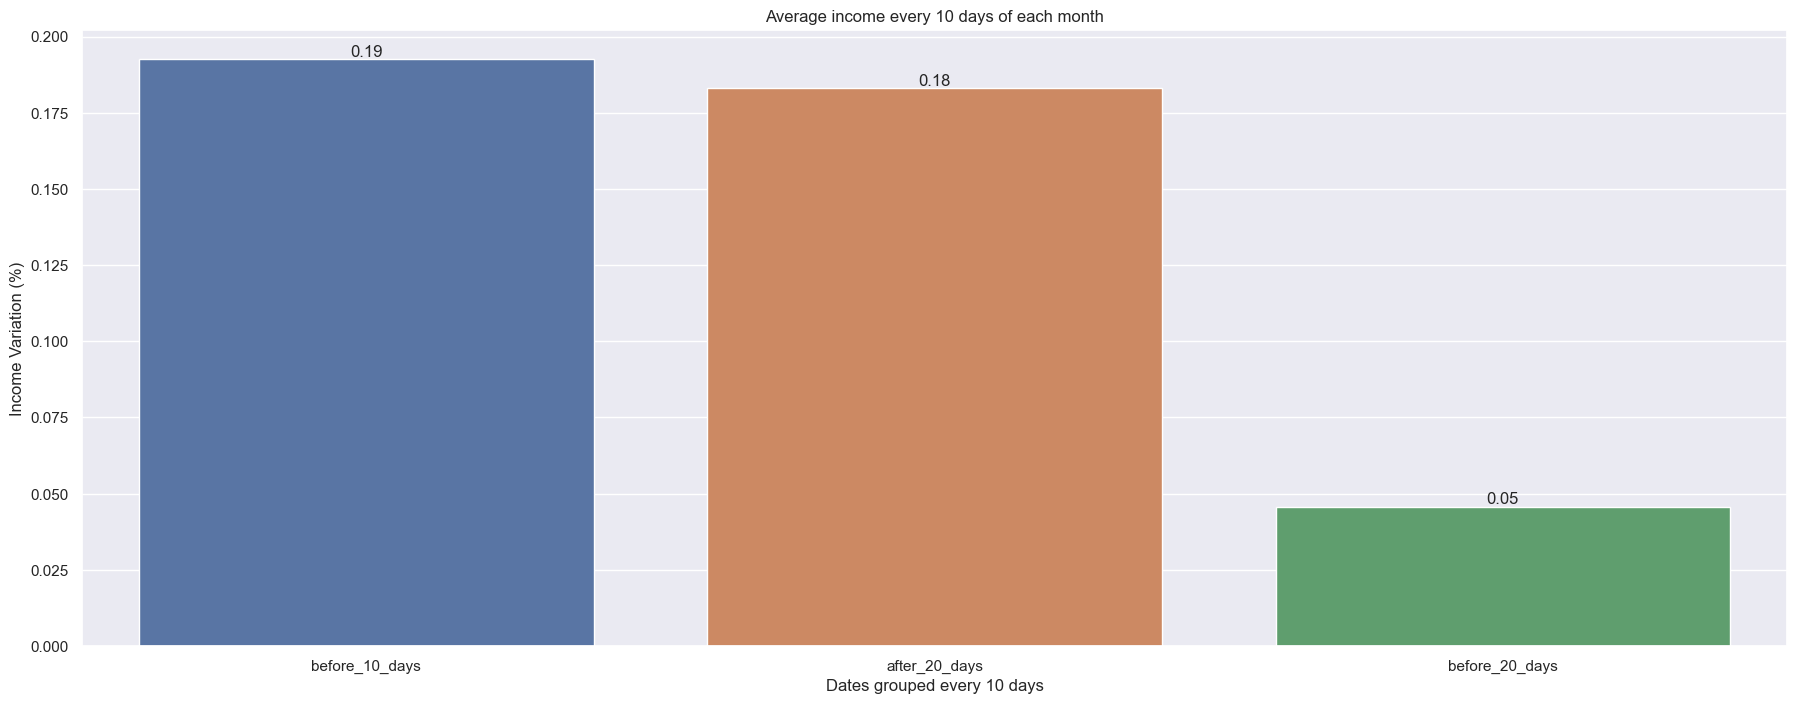

In [168]:
aux1 = aux.copy()
# Categorizing every 10 days
aux1['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else ('before_20_days' if x <= 20 else 'after_20_days'))

aux2 = aux1[['before_after', 'oil_comp_index']].groupby('before_after').mean().sort_values('oil_comp_index', ascending=False).reset_index()

# Plot config
plt.figure(figsize=(22,8))
sns.barplot(x='before_after', y='oil_comp_index', data=aux2)
plt.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Average income every 10 days of each month')
plt.xlabel('Dates grouped every 10 days')
plt.ylabel('Income Variation (%)');

### <s> H9. A 3ª semana de cada mês rendem em média 5% menos do que as demais semanas. </s> 

### H10. Empresas que o governo possui participação rendem em média 5% mais ao longo dos anos em comparação as demais.
**FALSE** Não há períodos onde a Petrobras se sobressai das demais empresas

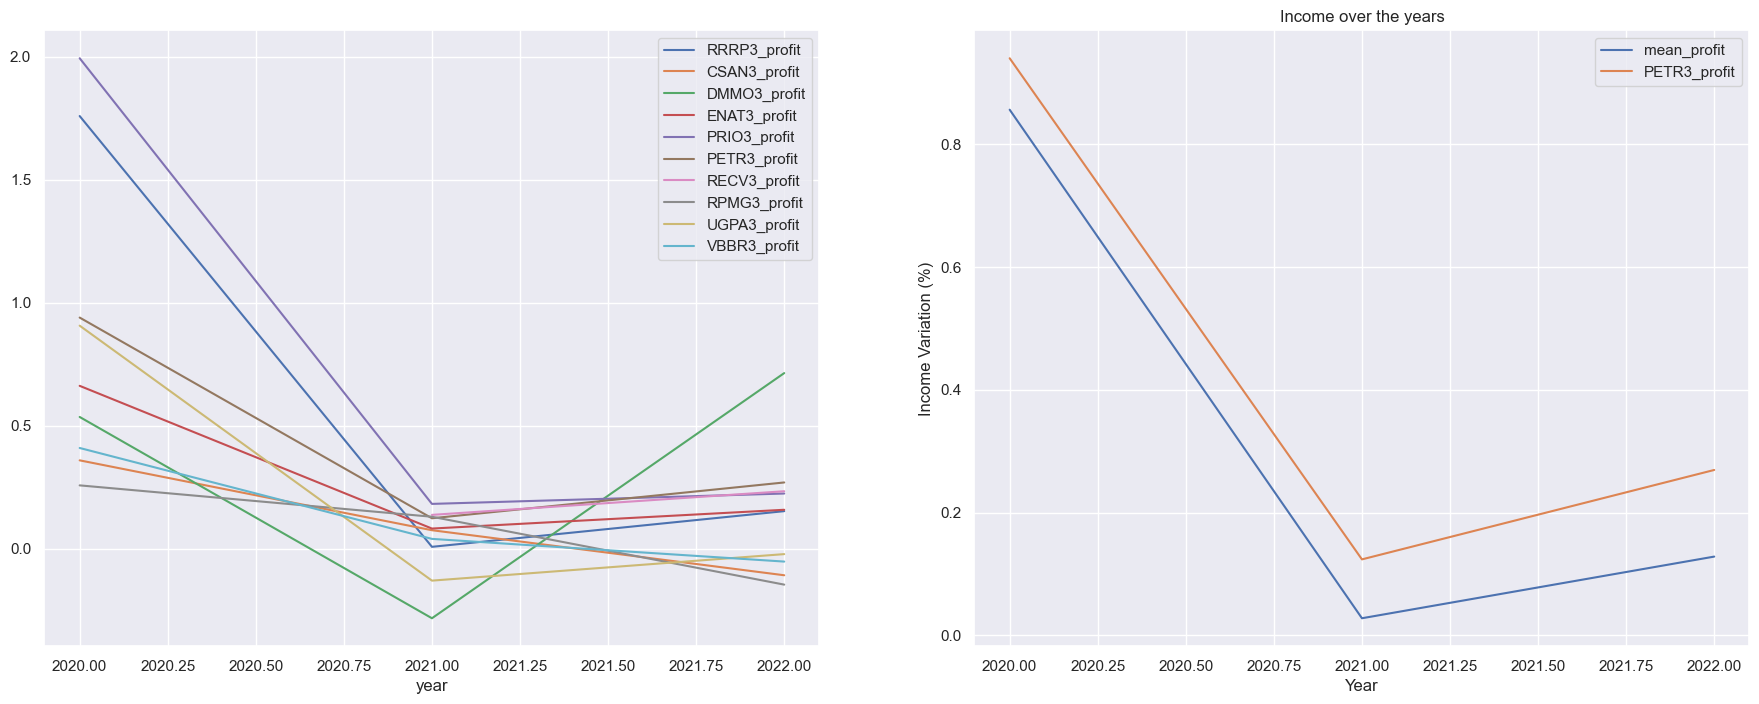

In [235]:
# Collecting Stock Yield Data for Individual Analysis
aux1 = df4[['RRRP3_profit', 'CSAN3_profit', 'DMMO3_profit',
       'ENAT3_profit', 'PRIO3_profit', 'PETR3_profit',
       'RECV3_profit', 'RPMG3_profit', 'UGPA3_profit',
       'VBBR3_profit', 'year']]

# Make mean of profit for all stock except PETR
aux2 = aux1.drop(columns=['PETR3_profit'])
aux2['mean_profit'] = aux2.drop(columns=['year']).mean(axis=1)

# Concat with PETR for comparison
aux3 = pd.concat([aux2[['mean_profit']], aux1[['PETR3_profit', 'year']]], axis=1)

# Make plot
plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1, 2, 1)
aux1.groupby('year').mean().plot(ax=ax1)

ax2 = plt.subplot(1, 2, 2)
aux3.groupby('year').mean().plot(ax=ax2)

plt.title('Income over the years')
plt.xlabel('Year')
plt.ylabel('Income Variation (%)');

- (Figure 1) It is possible to see that some stocks outperform Petrobras.

- (Figure 2) When averaged over the other stocks we notice a better performance by Petrobras.

In [215]:
aux1.groupby('year').mean()

,RRRP3_profit,CSAN3_profit,DMMO3_profit,ENAT3_profit,PRIO3_profit,PETR3_profit,RECV3_profit,RPMG3_profit,UGPA3_profit,VBBR3_profit
year,,,,,,,,,,
2020,1.759,0.359,0.536,0.662,1.994,0.940,NaN,0.258,0.907,0.410
2021,0.008,0.075,-0.283,0.082,0.182,0.124,0.138,0.130,-0.130,0.040
2022,0.153,-0.108,0.714,0.158,0.224,0.270,0.234,-0.146,-0.022,-0.052


- In summary, the hypothesis takes into consideration that Petrobras will be 5% above any other company, therefore I will consider figure 1 for analysis. For this scenario there is no year where Petrobras performance is superior.

### 4.2.1 Resumo das Hipóteses

In [236]:
tab = [['Hipóteses', 'Conclusão'],
       ['H1', 'Falsa'],
       ['H2', 'Verdadeira'],
       ['H3', 'Verdadeira'],
       ['H4', 'Falsa'],
       ['H5', 'Verdadeira'],
       ['H6', 'Falsa'],
       ['H7', 'Falsa'],
       ['H8', 'Falsa'],
       ['H9', '--'],
       ['H10', 'Falsa']
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão
-----------  -----------
H1           Falsa
H2           Verdadeira
H3           Verdadeira
H4           Falsa
H5           Verdadeira
H6           Falsa
H7           Falsa
H8           Falsa
H9           --
H10          Falsa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

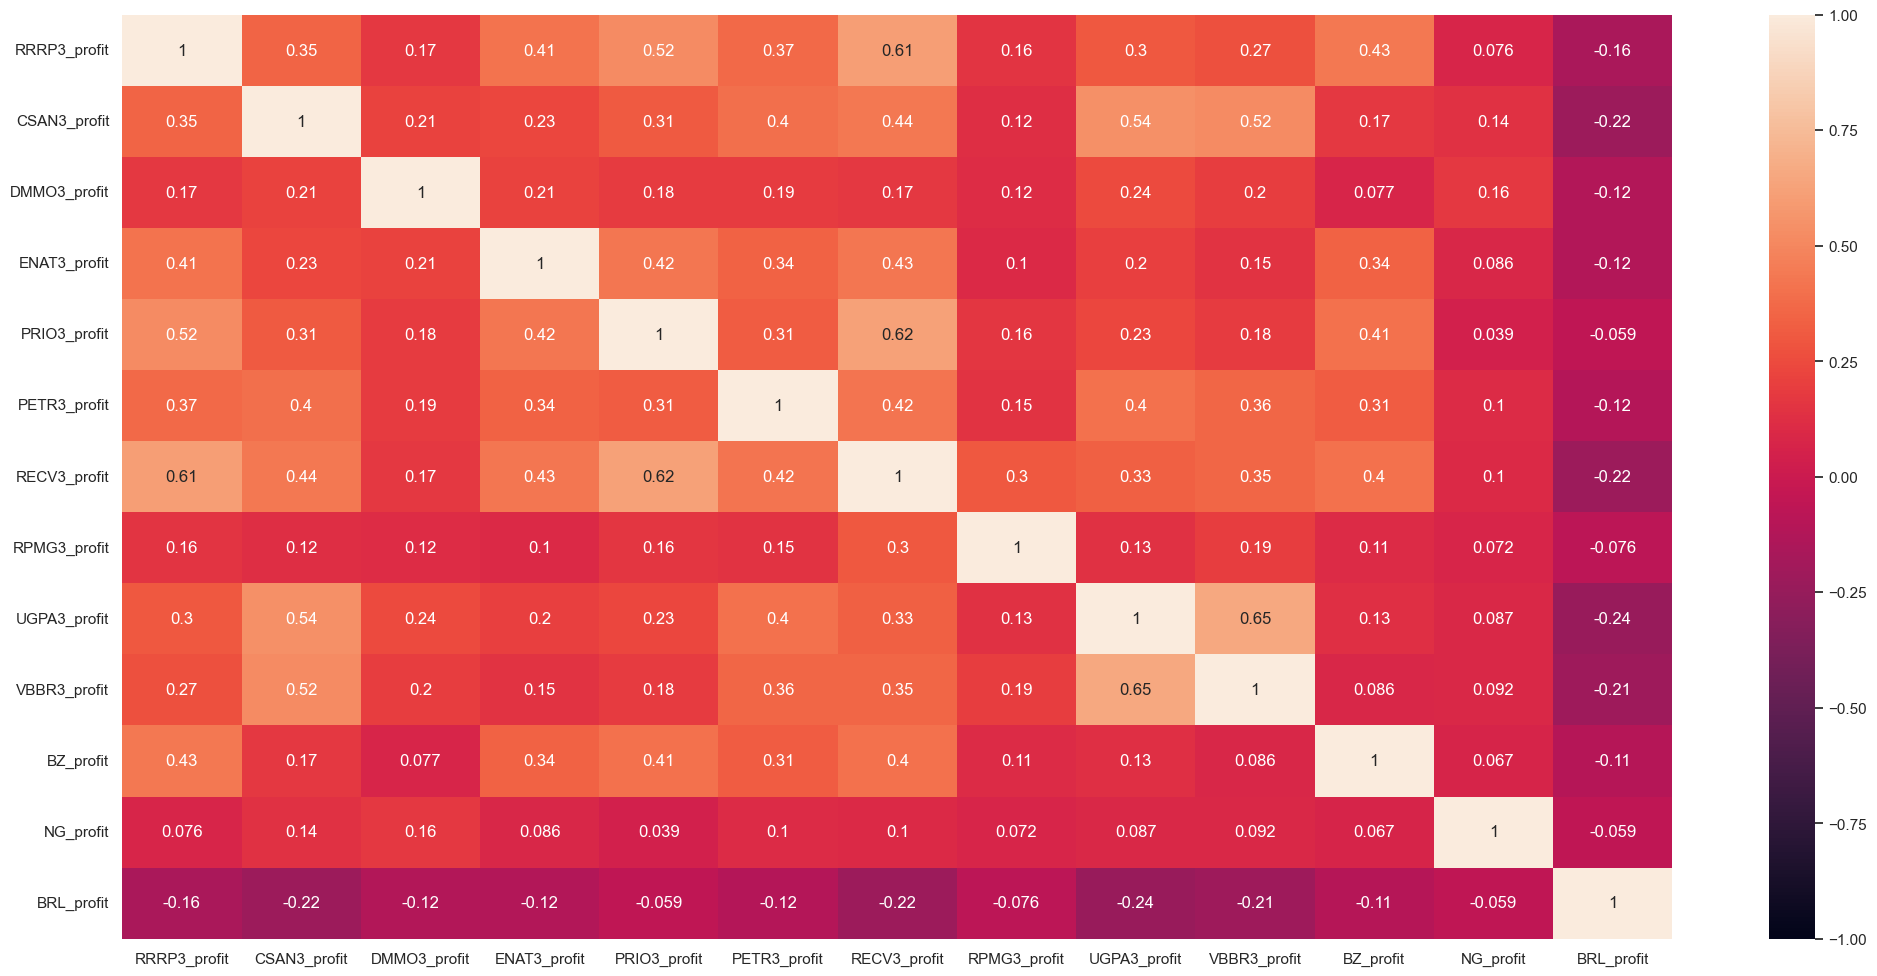

In [48]:
corr_list = ['RRRP3_profit', 'CSAN3_profit', 'DMMO3_profit',
            'ENAT3_profit', 'PRIO3_profit', 'PETR3_profit',
            'RECV3_profit', 'RPMG3_profit', 'UGPA3_profit',
            'VBBR3_profit', 'BZ_profit', 'NG_profit', 'BRL_profit']
            
sns.heatmap(df4[corr_list].corr(method='pearson'), annot=True, vmin=-1);

- Overall we have few strong correlations, although they are stocks from the same sector the volatility is probably linked to other external factors not captured by this data collection.